In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
from scipy import signal
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
import cmcrameri.cm as ccm
from obspy import Trace, Stream, UTCDateTime

%matplotlib inline
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

corr_path = '/Users/JQ/Desktop/Second_Project/SJC/'
dt = 1. / 50.

In [48]:
def bpfilter(data, dt, bp_low, bp_high):  # default: 4
    # sos = signal.butter(10, [bp_low, bp_high], btype='bandpass', fs=1/dt, output='sos')
    z, p, k = signal.iirfilter(4, [bp_low, bp_high], btype='band', ftype='butter', output='zpk', fs=1/dt)
    sos = signal.zpk2sos(z, p, k)
    return signal.sosfiltfilt(sos, data, axis=-1)

def lpfilter(data, dt, fl):
    sos = signal.butter(10, fl, btype='lp', fs=1/dt, output='sos')
    return signal.sosfiltfilt(sos, data, axis=-1)

def hpfilter(data, dt, fh):
    sos = signal.butter(10, fh, btype='hp', fs=1/dt, output='sos')
    return signal.sosfiltfilt(sos, data, axis=-1)

In [4]:
xcf_list = glob.glob(corr_path + 'xcorr_data_perpendicular/*all_hrs.npy')

xcf_list.sort(key=lambda x: int(os.path.basename(x).split('_')[2]))
xcf_list

['/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_0_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_1_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_2_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_3_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_4_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_5_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_6_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_7_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_8_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_9_all_hrs.npy',
 '/Users/JQ/Desktop/Second_Project/SJC/xcorr_data_perpendicular/xcorr_ivs_10_all_hrs.npy',
 '/Users/

In [5]:
### DAS channels metadata ###
metadata = pd.read_csv('./new_metadata_all.csv', index_col=0)

# Functions

In [6]:
### Parameters for profile ###
# Total length in second
tlen = 60
# Total number of points
Npts = int(tlen / dt + 1)
# Time axis
timestamp = np.linspace(-tlen/2, tlen/2, num=Npts, endpoint=True)

### Extract correlation data
def select_correlations(ind_pair, xcf_list):

    select_gather = []
    select_st = Stream()
    N_select = ind_pair.shape[0]

    # Time step
    dt = 1. / 50.

    for i in range(N_select):
        # Trace data
        tr_data = np.load(xcf_list[ind_pair['Ind1'].iloc[i]])[ind_pair['Ind2'].iloc[i]]
        tr_data = np.append(tr_data, 0.0)

        # Trace object
        tr = Trace(data=tr_data[::-1])
        tr.stats.delta = dt
        tr.stats.starttime = UTCDateTime(2000, 1, 1, 0, 0, 0)
        tr.stats.distance = ind_pair.iloc[i,2]

        select_gather.append(tr_data)
        select_st += tr

    select_gather = np.asarray(select_gather)
    
    return select_gather, select_st

In [7]:
### FK method from Ariel Lellouch ###

import math
import scipy

# FK transform, then convert k to phase velocity

def map_fk(gather, offset_pair, dx=5, dt=1./50., pos=True):
    
    half_t = gather.shape[1]//2
    d_off = dx
    
    if pos:
        interp_offs, interp_data = map_to_offset(gather[:, :half_t], offset_pair, d_off)
    else:
        interp_offs, interp_data = map_to_offset(gather[:, -1:half_t:-1], offset_pair, d_off)
    
    return scipy.fft.fftshift(scipy.fft.fft2(interp_data))
    
def map_fv(data, dx, dt, freqs, vels):
    (nch, nt) = np.shape(data)
    nscanv = np.size(vels)
    nscanf = np.size(freqs)
    nf = 2**(1+math.ceil(math.log(nt, 2)))
    nk = 2**(1+math.ceil(math.log(nch, 2)))

    fft_f = np.arange(-nf/2, nf/2)/nf/dt
    fft_k = np.arange(-nk/2, nk/2)/nk/dx

    fk_res = scipy.fft.fftshift(scipy.fft.fft2(data, s=[nk, nf]))
    fk_res = np.absolute(fk_res)

    interp_fun = scipy.interpolate.interp2d(fft_k, fft_f, fk_res.T, kind='cubic') # Transpose needed for interp2 definition

    # interp_fun = scipy.interpolate.RectBivariateSpline(fft_k, fft_f, fk_res)  # Supposed to be faster. So far isn't

    ones_arr = np.ones(shape=(nscanv,))
    fv_map = np.zeros(shape=(len(freqs), len(vels)), dtype=np.float32)
    for ind, fr in enumerate(freqs):
        fv_map[ind, :] = np.squeeze(interp_fun(np.divide(ones_arr*fr, vels), fr))

    return fv_map.T

# Interpolate traces to uniform spacing offset grid defined by d_off

def map_to_offset(data, offsets, d_off):
    n_chan, nt = np.shape(data)

    max_off = np.amax(offsets)
    min_off = np.amin(offsets)
    interp_offs = d_off * np.arange(int(np.floor(min_off/d_off))+1, int(np.ceil(max_off/d_off)))
    n_int_offs = np.size(interp_offs)

    sorting_ord = np.argsort(offsets)
    sorted_off = offsets[sorting_ord]
    sorted_data = data[sorting_ord, :]

    interpolator = scipy.interpolate.interp1d(sorted_off, np.arange(0, n_chan))
    interp_chans = interpolator(interp_offs)

    interp_data = np.zeros(shape=(n_int_offs, nt))
    interp_counter = np.zeros(shape=(n_int_offs,))

    for i in range(n_int_offs):
        interp_val = interp_chans[i] - np.floor(interp_chans[i])
        flr_chan = int(np.floor(interp_chans[i]))
        if interp_val == 0.0:
            interp_data[i, :] += sorted_data[flr_chan, :]
            interp_counter[i] += 1.0
        else:
            interp_data[i, :] = (1.0-interp_val) * sorted_data[flr_chan, :] + interp_val * sorted_data[flr_chan+1, :]
            interp_counter[i] += 1.0

    for i in range(n_int_offs):
        interp_data[i, :] /= interp_counter[i]

    return interp_offs, interp_data

# Calculate phase velocity dispersion

def calc_vph_disp(gather, offset_pair, freqs, vels, pos=True):

    half_t = gather.shape[1]//2

    d_off = 5
    
    if pos:
        interp_offs, interp_data = map_to_offset(gather[:, :half_t], offset_pair, d_off)
    else:
        interp_offs, interp_data = map_to_offset(gather[:, -1:half_t:-1], offset_pair, d_off)

    fv_map_arr = map_fv(interp_data, d_off, dt, freqs, vels)
    
    return fv_map_arr

# Normalization

def normfunc(X):
    return np.asarray([X[:,i]/(abs(X[:,i]).max()+1e-20) for i in range(X.shape[1])]).T

### Extract ridgeline based on reference curve

def extract_ridge(freq, vel, fv_map, func_vel=None, sigma=25):
    
    # Velocity unit is m/s: vel, func_vel, sigma
    # Shape of fv_map: (Nvel, Nfreq)
    
    # No reference curve
    if func_vel is None:
        return vel[np.argmax(fv_map, axis=0)]
    
    # Extract ridgeline around the given curve
    else:
        # Reference velocity
        vel_ref = func_vel(freq)
        
        # Mask dispersion map
        vel_2d = np.tile(vel[::-1], (len(freq), 1)).T
        mask = (vel_2d > (vel_ref - sigma)) & (vel_2d < (vel_ref + sigma))
        mask_fv_map = np.ma.masked_array(fv_map, mask=~mask)
        
        # Dispersion curve
        return vel[np.argmax(mask_fv_map, axis=0)]

In [8]:
### Wavelet analysis with instantaneous frequency correction ###
from xwt import myxwt, cwt
from scipy.interpolate import interp1d
from unwrap import unwrap
from scipy.interpolate import RectBivariateSpline

def stack_psd(stream, ind_pair, time_samp, vg_samp, freq_range, Nfreqs, wave_type):
    
    interp_type = 'linear'
    Nvg = len(vg_samp)
    
    # Distance range
    print('Maximum distance : %.2f m' %np.max(ind_pair['Distance']))
    print('Minimum distance : %.2f m' %np.min(ind_pair['Distance']))
    print('Average distance : %.2f m' %np.average(ind_pair['Distance']))
    print('Median distance : %.2f m' %np.median(ind_pair['Distance']))
    
    stack_cfs_p = np.zeros((Nfreqs, Nvg))
    stack_cfs_n = np.zeros((Nfreqs, Nvg))
    coi_p = np.zeros(Nvg)
    coi_n = np.zeros(Nvg)
    
    for cur_ind in tqdm(range(ind_pair.shape[0])):
    
        # Wavelet analysis
        trace = stream[cur_ind]
        _, cc_cfs, freqs, coi = cwt(trace.data, 1/dt, ns=3, nt=0.25, vpo=12, 
                                    freqmin=freq_range[0], freqmax=freq_range[1], nptsfreq=Nfreqs, smooth=True)
        
        # Positve branch
        mask_p = (time_samp > 0)
        cc_cfs_p = cc_cfs[:, mask_p]
        cc_cfs_p = cc_cfs_p / np.max(cc_cfs_p)
        
        # Negative branch
        mask_n = (time_samp < 0)
        cc_cfs_n = cc_cfs[:, mask_n]
        cc_cfs_n = cc_cfs_n / np.max(cc_cfs_n)
        
        # Interpolation to reference velocity samples
        fp = interp1d(ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_p], cc_cfs_p, 
                      kind=interp_type, bounds_error=False, fill_value=0)
        if wave_type is None:
            stack_cfs_p = stack_cfs_p + fp(vg_samp)
        else:
            stack_cfs_p = stack_cfs_p + fp(vg_samp) * np.abs(ind_pair.iloc[cur_ind][wave_type])
        
        fn = interp1d(-ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_n], cc_cfs_n, 
                      kind=interp_type, bounds_error=False, fill_value=0)
        if wave_type is None:
            stack_cfs_n = stack_cfs_n + fn(vg_samp)
        else:
            stack_cfs_n = stack_cfs_n + fn(vg_samp) * np.abs(ind_pair.iloc[cur_ind][wave_type])
        
        # Cone of instability
        fp_coi = interp1d(ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_p], coi[mask_p], 
                          kind=interp_type, bounds_error=False, fill_value=0)
        coi_p = np.max(np.array([coi_p, fp_coi(vg_samp)]), axis=0)
        
        fn_coi = interp1d(-ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_n], coi[mask_n], 
                          kind=interp_type, bounds_error=False, fill_value=0)
        coi_n = np.max(np.array([coi_n, fn_coi(vg_samp)]), axis=0)
    
    return freqs, stack_cfs_p, stack_cfs_n, coi_p, coi_n

def stack_psd_correction(stream, ind_pair, time_samp, vg_samp, filt_range, measure_range, Nfreqs, wave_type, smooth=True):
    
    interp_type = 'linear'
    Nvg = len(vg_samp)
    
    # Distance range
    print('Maximum distance : %.2f m' %np.max(ind_pair['Distance']))
    print('Minimum distance : %.2f m' %np.min(ind_pair['Distance']))
    print('Average distance : %.2f m' %np.average(ind_pair['Distance']))
    print('Median distance : %.2f m' %np.median(ind_pair['Distance']))
    
    stack_cfs_p = np.zeros((Nfreqs, Nvg))
    stack_cfs_n = np.zeros((Nfreqs, Nvg))
    coi_p = np.zeros(Nvg)
    coi_n = np.zeros(Nvg)
    freqs = np.linspace(measure_range[0], measure_range[1], Nfreqs)
    
    # Extend frequency axis to account for potential instantaneous correction
    _freq_range = [filt_range[0], filt_range[1]]
    _Nfreqs = np.ceil(Nfreqs*1.2).astype(int)
    
    for cur_ind in tqdm(range(ind_pair.shape[0])):
    
        # Wavelet analysis
        trace = stream[cur_ind]
        cc_cwt, cc_cfs, _freqs, coi = cwt(trace.data, 1/dt, ns=3, nt=0.25, vpo=12, 
                                          freqmin=_freq_range[1], freqmax=_freq_range[0], nptsfreq=_Nfreqs, 
                                          smooth=smooth)
        
        # Positve branch
        mask_p = (time_samp > 0)
        cc_cfs_p = cc_cfs[:, mask_p]
        # cc_cfs_p = cc_cfs_p / np.max(cc_cfs_p)
        
        # Negative branch
        mask_n = (time_samp < 0)
        cc_cfs_n = cc_cfs[:, mask_n]
        # cc_cfs_n = cc_cfs_n / np.max(cc_cfs_n)
        
        ### Ridgeline (group arrival time)
        tg_p_ind = np.nanargmax(cc_cfs_p, axis=1)
        tg_n_ind = np.nanargmax(cc_cfs_n, axis=1)
        tg_p = (time_samp[mask_p])[tg_p_ind]
        tg_n = (time_samp[mask_n])[tg_n_ind]

        ### Correction for instantaneous frequency
        cwt_phase = unwrap(np.angle(cc_cwt))
        phi1_p = (cwt_phase[:,mask_p])[np.arange(0, _Nfreqs), tg_p_ind-1]
        phi2_p = (cwt_phase[:,mask_p])[np.arange(0, _Nfreqs), tg_p_ind]
        freqs_ins_p = (phi2_p - phi1_p) / dt / (2*np.pi)
        idx_p = np.argsort(freqs_ins_p)
        freqs_ins_p = freqs_ins_p[idx_p]

        phi1_n = (cwt_phase[:,mask_n])[np.arange(0, _Nfreqs), tg_n_ind-1]
        phi2_n = (cwt_phase[:,mask_n])[np.arange(0, _Nfreqs), tg_n_ind]
        freqs_ins_n = (phi2_n - phi1_n) / dt / (2*np.pi)
        idx_n = np.argsort(freqs_ins_n)
        freqs_ins_n = freqs_ins_n[idx_n]
        
        # Interpolation to reference velocity samples
        if not np.all(np.diff(freqs_ins_p) > 0.0):
            print('Trace %d positive branch skipped.' %cur_ind)
        else: 
            fp = RectBivariateSpline(freqs_ins_p, 
                                     np.flip(ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_p]), 
                                     np.flip(cc_cfs_p[idx_p, :], axis=1))
            if wave_type is None:
                stack_cfs_p = stack_cfs_p + fp(freqs, vg_samp)
            else:
                stack_cfs_p = stack_cfs_p + fp(freqs, vg_samp) * np.abs(ind_pair.iloc[cur_ind][wave_type])
        
        if not np.all(np.diff(freqs_ins_n) > 0.0):
            print('Trace %d negative branch skipped.' %cur_ind)
        else: 
            fn = RectBivariateSpline(freqs_ins_n, 
                                     -ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_n], 
                                     cc_cfs_n[idx_n, :])
            if wave_type is None:
                stack_cfs_n = stack_cfs_n + fn(freqs, vg_samp)
            else:
                stack_cfs_n = stack_cfs_n + fn(freqs, vg_samp) * np.abs(ind_pair.iloc[cur_ind][wave_type])
        
        # Cone of instability
        fp_coi = interp1d(ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_p], coi[mask_p], 
                          kind=interp_type, bounds_error=False, fill_value=0)
        coi_p = np.max(np.array([coi_p, fp_coi(vg_samp)]), axis=0)
        
        fn_coi = interp1d(-ind_pair.iloc[cur_ind]['Distance']/time_samp[mask_n], coi[mask_n], 
                          kind=interp_type, bounds_error=False, fill_value=0)
        coi_n = np.max(np.array([coi_n, fn_coi(vg_samp)]), axis=0)
    
    return freqs, stack_cfs_p, stack_cfs_n, coi_p, coi_n

def calc_vg_disp(trace, freq_range, Nfreqs, smooth=False, plot=False):
    
    ### Wavelet transform
    cc_cwt, cc_cfs, freqs, coi = cwt(trace.data, 1/dt, ns=3, nt=0.25, vpo=12, freqmin=freq_range[0], 
                                     freqmax=freq_range[1], nptsfreq=Nfreqs, smooth=smooth)
    
    ### Phase of wavelet transform
    cwt_phase = unwrap(np.angle(cc_cwt))
    
    ### Remove outliers
    filt_cfs = cc_cfs.copy()
    
    # Criteria (optional)
    mask_freq = (freqs > 8)
    mask_time = (trace.stats.distance/np.abs(timestamp) > 300) | (trace.stats.distance/np.abs(timestamp) < 100)
    
    # Filtered WT results (optional)
    filt_cfs[np.ix_(mask_freq), :] = np.nan
    filt_cfs[:, np.ix_(mask_time)] = np.nan
    
    ### Ridgeline (group arrival time)
    tg_p_ind = np.nanargmax(filt_cfs[:, mask_p], axis=1)
    tg_n_ind = np.nanargmax(filt_cfs[:, mask_n], axis=1)
    tg_p = (timestamp[mask_p])[tg_p_ind]
    tg_n = (timestamp[mask_n])[tg_n_ind]
    
    ### Group velocity
    vg_p = trace.stats.distance / tg_p
    vg_n = -trace.stats.distance / tg_n
    
    ### Correction for instantaneous frequency
    phi1_p = (cwt_phase[:,mask_p])[np.arange(0, Nfreqs), tg_p_ind-1]
    phi2_p = (cwt_phase[:,mask_p])[np.arange(0, Nfreqs), tg_p_ind]
    freqs_ins_p = (phi2_p - phi1_p) / dt / (2*np.pi)

    phi1_n = (cwt_phase[:,mask_n])[np.arange(0, Nfreqs), tg_n_ind-1]
    phi2_n = (cwt_phase[:,mask_n])[np.arange(0, Nfreqs), tg_n_ind]
    freqs_ins_n = (phi2_n - phi1_n) / dt / (2*np.pi)
    
    ### Make plots if needed
    if plot:
        
        # Raw measurement
        fig, ax = plt.subplots(figsize=(20,8))
        obj = ax.pcolormesh(timestamp, freqs, np.log10(filt_cfs), cmap='jet', edgecolors='none')
        ax.plot(timestamp, 1/coi, 'w--', linewidth=2)
        ax.scatter(tg_p, freqs, color='k', s=20)
        ax.scatter(tg_n, freqs, color='k', s=20)
        ax.scatter(tg_p, freqs_ins_p, color='w', s=20)
        ax.scatter(tg_n, freqs_ins_n, color='w', s=20)
        ax.set_xlabel('Lag Time [s]')
        ax.set_xlim(-5, 5)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_yscale('linear')
        ax.set_ylim(freq_range)
        plt.show()
    
    ### Return outputs
    return np.array([freqs_ins_p, freqs_ins_n]), np.array([vg_p, vg_n])

In [9]:
### Plot ray paths ###

import pyproj

# Earth Geod model
geodesic = pyproj.Geod(ellps='WGS84')

# DAS channel location
geom = pd.read_csv('./channel_location.csv')
lat_arr_raw = geom['lat'].values
lat_arr = lat_arr_raw[15::10]
lon_arr_raw = geom['long'].values
lon_arr = lon_arr_raw[15::10]

# Remove problematic channels (No.165 - No.173)
lat_arr = np.delete(lat_arr, np.s_[165:174])
lon_arr = np.delete(lon_arr, np.s_[165:174])

# Conversion to meter
lat_ave = np.average(lat_arr)
lon_ave = np.average(lon_arr)
Nch = len(lat_arr)
_, _, lat_arr_m = geodesic.inv([lon_ave]*Nch, lat_arr, [lon_ave]*Nch, [lat_arr[0]]*Nch)
_, _, lon_arr_m = geodesic.inv(lon_arr, [lat_ave]*Nch, [lon_arr[0]]*Nch, [lat_ave]*Nch)

lat_arr_m = np.array(lat_arr_m)
lon_arr_m = np.array(lon_arr_m)

def plot_path_coverage(ind_pair, lat, lon, ax=None, plot_label=False):
    
    if ax is None:
        flag = 0
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        flag = 1
    
    ax.plot(lon[:70], lat[:70], 'b', linewidth=5)
    ax.plot(lon[70:130], lat[70:130], 'r', linewidth=5)
    ax.plot(lon[130:200], lat[130:200], 'g', linewidth=5)
    ax.axis('equal')
    
    if plot_label:
        ax.set_xlabel('Easting [m]')
        ax.set_ylabel('Northing [m]')
    
    for i in range(ind_pair.shape[0]):
        ind1 = ind_pair['Ind1'].iloc[i]
        ind2 = ind_pair['Ind2'].iloc[i]
        
        ax.plot(lon[[ind1, ind2]], lat[[ind1, ind2]], 'gray', linewidth=1)
        # ax.plot(lon[[ind1, ind2]], lat[[ind1, ind2]], 'k--', linewidth=5)
        if np.mod(i, 2) == 0:
            ax.scatter(lon[ind1], lat[ind1], s=200, c='yellow', marker='*', edgecolors='k', zorder=10)
            ax.scatter(lon[ind2], lat[ind2], s=150, c='k', marker='^', zorder=10)
    
    if not flag:
        fig.tight_layout(pad=1.0)
        return [fig, ax]

In [10]:
### Measurement at specific frequencies ###
def measure_vph_disp_plot(freq, vel, fv_map, freq_samples, threshold=0.9, check=False, vel_offset=25):
    
    dv = vel[0] - vel[1]
    
    # Frequency samples
    ind_freq = np.array([np.argmin(np.abs(freq - freq_samp)) for freq_samp in freq_samples])
    Nsamp = ind_freq.shape[0]
    
    # Peak point
    ind_vel_mean = np.argmax(fv_map[:, ind_freq], axis=0)
    vel_mean = vel[ind_vel_mean]
    amp_peak = fv_map[ind_vel_mean, ind_freq]
    
    # Uncertainty (default: 1-sigma)
    ind_max = np.array([ind_v - np.argmax(fv_map[ind_v::-1, ind_f] < amp*threshold) 
                         for (ind_v, ind_f, amp) in zip(ind_vel_mean, ind_freq, amp_peak)])
    ind_min = np.array([ind_v + np.argmax(fv_map[ind_v:, ind_f] < amp*threshold) 
                         for (ind_v, ind_f, amp) in zip(ind_vel_mean, ind_freq, amp_peak)])
    
    # Outlier check
    if check:
        for ind in range(1, Nsamp-1):
            if (np.abs(vel_mean[ind]-vel_mean[ind-1]) > vel_offset) & (np.abs(vel_mean[ind+1]-vel_mean[ind]) > vel_offset):
                ind_vel_mean[ind] = ind_max[ind-1] - int(vel_offset/(2*dv)) + \
                    np.argmax(fv_map[ind_max[ind-1]-int(vel_offset/(2*dv)):ind_min[ind-1]+int(vel_offset/(2*dv)), ind_freq[ind]])
                ind_max[ind] = ind_vel_mean[ind] - np.argmax(fv_map[ind_vel_mean[ind]::-1, ind_freq[ind]] < fv_map[ind_vel_mean[ind], ind_freq[ind]]*threshold)
                ind_min[ind] = ind_vel_mean[ind] + np.argmax(fv_map[ind_vel_mean[ind]:, ind_freq[ind]] < fv_map[ind_vel_mean[ind], ind_freq[ind]]*threshold)

        # Output as with increasing period
        return (freq[ind_freq])[-2::-1], (vel[ind_vel_mean])[-2::-1], (vel[ind_min])[-2::-1], (vel[ind_max])[-2::-1]
    
    else:
        return (freq[ind_freq])[::-1], (vel[ind_vel_mean])[::-1], (vel[ind_min])[::-1], (vel[ind_max])[::-1]

def measure_disp_plot(freq, vel, fv_map, freq_samples, threshold=0.9, func_vel=None, vel_offset=25):
    
    if freq[1] - freq[0] < 0:
        raise Exception('Frequency points should be of increasing order!')
    
    dv = vel[1] - vel[0]
    if dv < 0:
        raise Exception('Velocity points should be of increasing order!')
        
    # Frequency samples
    ind_freq = np.array([np.argmin(np.abs(freq - freq_samp)) for freq_samp in freq_samples])
    Nsamp = ind_freq.shape[0]
    
    # Peak point
    if func_vel is None:
        ind_vel_mean = np.argmax(fv_map[:, ind_freq], axis=0)
        vel_mean = vel[ind_vel_mean]
        amp_peak = fv_map[ind_vel_mean, ind_freq]
        
    else:
        # Reference velocity
        vel_ref = func_vel(freq)
        
        # Mask dispersion map
        vel_2d = np.tile(vel, (len(freq), 1)).T
        mask = (vel_2d > (vel_ref - vel_offset)) & (vel_2d < (vel_ref + vel_offset))
        mask_fv_map = np.ma.masked_array(fv_map, mask=~mask)
        
        ind_vel_mean = np.argmax(mask_fv_map[:, ind_freq], axis=0)
        vel_mean = vel[ind_vel_mean]
        amp_peak = fv_map[ind_vel_mean, ind_freq]
        
        
    # Uncertainty (default: 1-sigma)
    ind_min = np.array([ind_v - np.argmax(fv_map[ind_v::-1, ind_f] < amp*threshold) 
                         for (ind_v, ind_f, amp) in zip(ind_vel_mean, ind_freq, amp_peak)])
    ind_max = np.array([ind_v + np.argmax(fv_map[ind_v:, ind_f] < amp*threshold) 
                         for (ind_v, ind_f, amp) in zip(ind_vel_mean, ind_freq, amp_peak)])

    # Output as with increasing period
    return (freq[ind_freq])[::-1], (vel[ind_vel_mean])[::-1], (vel[ind_min])[::-1], (vel[ind_max])[::-1]

In [11]:
### Apply Gaussian window ###
def window_trace(time_samp, stream, ref_vel, dv, min_win=0.25, taper=0.2):
    
    win_gather = []
    win_st = Stream()

    for trace in stream:

        data = trace.data
        sta_dist = trace.stats.distance

        # Create flat window with Gaussian taper
        shift = sta_dist / ref_vel
        win_len = sta_dist * dv / ref_vel**2
        win_len = np.max((win_len, min_win))
        sigma = win_len * taper
        win_p = (time_samp > shift+win_len) * (np.exp(-(time_samp-shift-win_len)**2 / (2*sigma**2)) - 1) \
              + (time_samp < shift-win_len) * (np.exp(-(time_samp-shift+win_len)**2 / (2*sigma**2)) - 1) \
              + 1
        win_n = (time_samp < -shift-win_len) * (np.exp(-(time_samp+shift+win_len)**2 / (2*sigma**2)) - 1) \
              + (time_samp > -shift+win_len) * (np.exp(-(time_samp+shift-win_len)**2 / (2*sigma**2)) - 1) \
              + 1
        
        # plt.plot(time_samp, win_p, time_samp, win_n)
        
        win_func = np.maximum(win_p, win_n)
        
        # Windowed trace
        data_win = data * win_func

        # Windowed profile
        tr = Trace(data=data_win)
        tr.stats.delta = dt
        tr.stats.starttime = UTCDateTime(2000, 1, 1, 0, 0, 0)
        tr.stats.distance = sta_dist

        win_gather.append(np.flip(data_win))
        win_st += tr

    win_gather = np.asarray(win_gather)
    
    return win_gather, win_st

### Change stream to gather ###
def stream_to_gather(stream):
    gather = []
    
    for trace in stream:
        gather.append(np.flip(trace.data))
    
    gather = np.asarray(gather)
    return gather

### Change gather to stream ###
def gather_to_stream(gather, ind_pair):
    stream = Stream()
    
    for i in range(gather.shape[0]):
        
        tr = Trace(data=gather[i, ::-1])
        tr.stats.delta = dt
        tr.stats.starttime = UTCDateTime(2000, 1, 1, 0, 0, 0)
        tr.stats.distance = ind_pair.iloc[i,2]

        stream += tr
    return stream

# Select example cases

In [45]:
# Case to plot
case = 1
# Bandpass filter
filt_range = [0.5, 10]  # [0.5, 10]

# Reference velocity for Rayleigh and Love waves
ref_vel_R = 751.29 / 2.7    # 278.25
ref_vel_L = 751.29 / 4.4    # 170.75

if case == 1:
    mask1 = (metadata['Ind1'] == 135) & (metadata['Distance'] <= 632)
    mask2 = (abs(metadata['Love']) >= 0.2) & (metadata['Rayleigh'] < 0.1) & (metadata['Distance'] >= 630)
    sort1_param = {"by":'Ind2', "ascending":True}
    sort2_param = {"by":'Distance', "ascending":True}
    factor_ylim = [[-0.05, 1.05], [-0.0125, 0.2625]]
    time_dots_color = ["black", "lime"]
    window_param = {"R":{"ref_vel":ref_vel_R, "dv":0, "min_win":1.0, "taper":0.25}}
    
elif case == 2:
    mask1 = (metadata['Ind1'] + metadata['Ind2'] == 140) & (metadata['Ind2'] > 70) & (metadata['Ind2'] < 130)
    mask2 = (metadata['Ind2'] - metadata['Ind1'] == 120) & (metadata['Ind2'] >= 135) & (metadata['Ind1'] < 70)
    sort1_param = {"by":'Ind2', "ascending":True}
    sort2_param = {"by":'Ind2', "ascending":True}
    factor_ylim = [[0.1, 0.3], [0.1, 0.3]]
    window_param = {"L":{"ref_vel":160, "dv":30, "min_win":0.3, "taper":0.25}}
    
elif case == 3:
    mask1 = (metadata['Ind1'] + metadata['Ind2'] == 260) & (metadata['Ind2'] > 130) & (metadata['Ind1'] >= 70)
    mask2 = (metadata['Ind2'] - metadata['Ind1'] == 120) & (metadata['Ind2'] >= 135) & (metadata['Ind1'] < 70)
    sort1_param = {"by":'Ind2', "ascending":True}
    sort2_param = {"by":'Ind2', "ascending":False}
    factor_ylim = [[0.1, 0.3], [0.1, 0.3]]
    
elif case == 4:
    mask1 = (metadata['Ind1'] == 0) & (metadata['Ind2'] <= 65)
    mask2 = (metadata['Ind1'] == 135) & (metadata['Ind2'] <= 200)
    sort1_param = {"by":'Distance', "ascending":True}
    sort2_param = {"by":'Distance', "ascending":True}
    window_param = {"R":{"ref_vel":ref_vel_R, "dv":0, "min_win":1.0, "taper":0.25}}

In [46]:
### Select cross-correlation traces

# Select indices
ind_pair1 = metadata[mask1]
ind_pair1 = ind_pair1.sort_values(**sort1_param)
ind_pair2 = metadata[mask2]
ind_pair2 = ind_pair2.sort_values(**sort2_param)
ind_pair = pd.concat([ind_pair1, ind_pair2])

# Select traces
select_gather1, select_st1 = select_correlations(ind_pair1, xcf_list)
select_gather2, select_st2 = select_correlations(ind_pair2, xcf_list)
select_gather, select_st = select_correlations(ind_pair, xcf_list)

# Offset
offset1 = ind_pair1['Distance'].to_numpy()
offset2 = ind_pair2['Distance'].to_numpy()
offset = ind_pair['Distance'].to_numpy()

# Filter
select_st.filter(type='bandpass', freqmin=filt_range[0], freqmax=filt_range[1], zerophase=True)
select_gather = bpfilter(select_gather, dt, filt_range[0], filt_range[1])

# Profiles

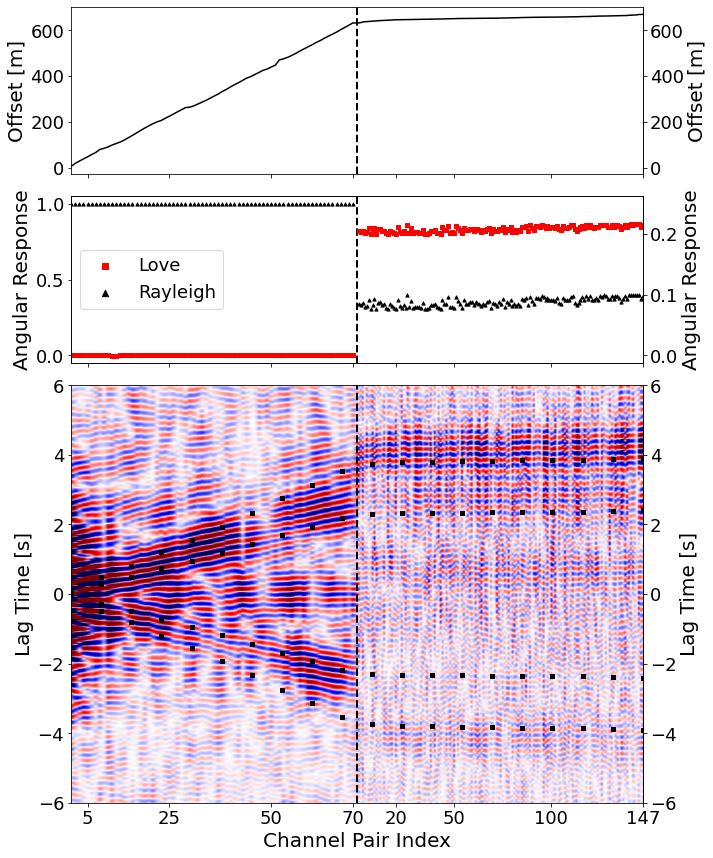

In [47]:
### Plot profiles
apply_window = False
wave_type = 'L'

### Plotting
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

N1 = len(ind_pair1)
N2 = len(ind_pair2)
vline = 1
x1_data = np.linspace(0, vline, N1+1)[:-1]
x2_data = np.linspace(vline, 2*vline, N2+1)[1:]
x_data = np.concatenate((x1_data, x2_data))

x_sparse = np.linspace(0,2*vline,20)
interp_offset = interp1d(x_data, ind_pair['Distance'])
offset_sparse = interp_offset(x_sparse)
ref_line_size = 10

# Channel pair index
x1_index = np.array([5, 25, 50, N1])
x2_index = np.array([20, 50, 100, N2])

if apply_window:
    plot_gather, plot_st = window_trace(timestamp, select_st, **window_param[wave_type])
    
else:
    plot_gather = select_gather
    plot_st = select_st

for i in range(1):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 12),
                                        gridspec_kw={'height_ratios': [1, 1, 2.5]})

    ax1.plot(x_data, ind_pair['Distance'], 'k-')
    ax1.axvline(vline, linestyle='dashed', color='k', linewidth=2)
    ax1.set_ylabel('Offset [m]')
    secax1 = ax1.secondary_yaxis('right')
    secax1.set_ylabel('Offset [m]')
    
    ax2_2 = ax2.twinx()
    obj1 = ax2_2.scatter(x2_data, ind_pair2['Love'], s=10, c='r', marker='s')
    obj1_2 = ax2_2.scatter(x2_data, ind_pair2['Rayleigh'], s=10, c='k', marker='^')
    obj3 = ax2.scatter(x1_data, ind_pair1['Rayleigh'], s=10, c='k', marker='^')
    obj3_2 = ax2.scatter(x1_data, ind_pair1['Love'], s=10, c='r', marker='s')
    ax2.axvline(vline, linestyle='dashed', color='k', linewidth=2)
    ax2.set_ylim(factor_ylim[0])
    ax2_2.set_ylim(factor_ylim[1])
    ax2.set_ylabel('Angular Response')
    ax2_2.set_ylabel('Angular Response')
    ax2.legend([obj1, obj3], ['Love', 'Rayleigh'], loc='center left', markerscale=2)

    if i == 0:
        clim = 2e-1
        ax3.pcolormesh(x_data, timestamp, np.flip(plot_gather[:,:].T, axis=0), vmin=-clim, vmax=clim, 
                      cmap='seismic', shading='gouraud')
    else:
        clim = 1
        plot_envelope = np.abs(signal.hilbert(plot_gather, axis=1))
        plot_envelope = (normfunc(plot_envelope.T)).T
        ax3.pcolormesh(x_data, timestamp, np.flip(plot_envelope[:,:].T, axis=0), vmin=0, vmax=clim, 
                      cmap='inferno', shading='gouraud')
        
    ax3.axvline(vline, linestyle='dashed', color='k', linewidth=2)
    ax3.set_xlim([0, 2*vline])
    ax3.set_ylim([-6, 6])
    ax3.set_ylabel('Lag Time [s]')
    secax3 = ax3.secondary_yaxis('right')
    secax3.set_ylabel('Lag Time [s]')
    
    # ax3.get_xaxis().set_visible(False)
    ax3.set_xticks(np.concatenate((x1_data[x1_index-1], x2_data[x2_index-1])), 
                   np.concatenate((x1_index, x2_index)))
    ax3.set_xlabel('Channel Pair Index')

    ref_line_color = time_dots_color[i]
    ref_time_L = offset_sparse / ref_vel_L
    ax3.scatter(x_sparse, ref_time_L, s=ref_line_size, c=ref_line_color, marker='s')
    ax3.scatter(x_sparse, -ref_time_L, s=ref_line_size, c=ref_line_color, marker='s')

    ref_time_R = offset_sparse / ref_vel_R
    ax3.scatter(x_sparse, ref_time_R, s=ref_line_size, c=ref_line_color, marker='s')
    ax3.scatter(x_sparse, -ref_time_R, s=ref_line_size, c=ref_line_color, marker='s')
    
    fig.tight_layout(pad=1.0)
    # plt.show(fig)
    # plt.savefig('./profile_new/Ex1_1_ppt.png', dpi=300)

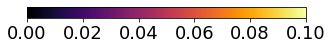

In [1278]:
from matplotlib.colors import Normalize
fig_c, ax_c = plt.subplots(1, figsize=(5,0.2))
fig_c.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0, vmax=1, clip=False), cmap='inferno'), 
               cax=ax_c, orientation='horizontal')
fig_c.tight_layout(pad=1.0)
# plt.show(fig_c)
# plt.savefig('./profile_new/inferno_2.png', dpi=300, facecolor='w', bbox_inches='tight')

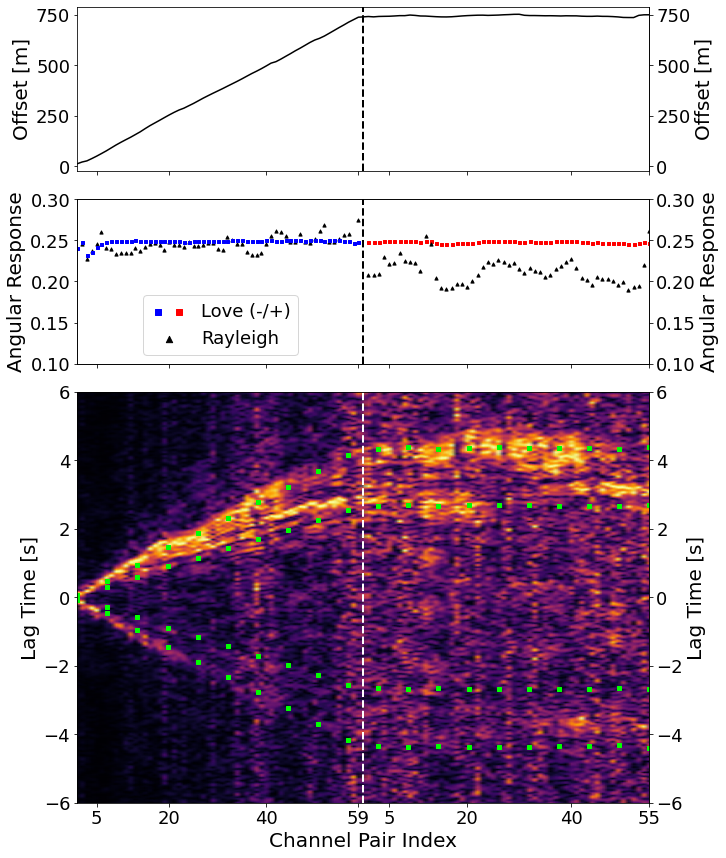

In [1738]:
### Plot profiles
apply_window = False
wave_type = 'L'

### Plotting
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

N1 = len(ind_pair1)
N2 = len(ind_pair2)
vline = 1
x1_data = np.linspace(0, vline, N1+1)[:-1]
x2_data = np.linspace(vline, 2*vline, N2+1)[1:]
x_data = np.concatenate((x1_data, x2_data))

x_sparse = np.linspace(0,2*vline,20)
interp_offset = interp1d(x_data, ind_pair['Distance'])
offset_sparse = interp_offset(x_sparse)
ref_line_size = 10

# Channel pair index
x1_index = np.array([5, 20, 40, N1])
x2_index = np.array([5, 20, 40, N2])

if apply_window:
    plot_gather, plot_st = window_trace(timestamp, select_st, **window_param[wave_type])
    
else:
    plot_gather = select_gather
    plot_st = select_st

for i in range(1,2):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 12),
                                        gridspec_kw={'height_ratios': [1, 1, 2.5]})

    ax1.plot(x_data, ind_pair['Distance'], 'k-')
    ax1.axvline(vline, linestyle='dashed', color='k', linewidth=2)
    ax1.set_ylabel('Offset [m]')
    secax1 = ax1.secondary_yaxis('right')
    secax1.set_ylabel('Offset [m]')
    
    ax2_2 = ax2.twinx()
    obj1 = ax2_2.scatter(x2_data, ind_pair2['Love'], s=9, c='r', marker='s')
    obj1_2 = ax2_2.scatter(x2_data, ind_pair2['Rayleigh'], s=10, c='k', marker='^')
    obj3 = ax2.scatter(x1_data, ind_pair1['Rayleigh'], s=10, c='k', marker='^')
    obj3_2 = ax2.scatter(x1_data, -ind_pair1['Love'], s=9, c='b', marker='s')
    ax2.axvline(vline, linestyle='dashed', color='k', linewidth=2)
    ax2.set_ylim(factor_ylim[0])
    ax2_2.set_ylim(factor_ylim[1])
    ax2.set_ylabel('Angular Response')
    ax2_2.set_ylabel('Angular Response')
    ax2.legend([(obj3_2, obj1), obj3], ['Love (-/+)', 'Rayleigh'], loc='lower left', markerscale=2,
               bbox_to_anchor=(0.1,0),
               handler_map={tuple: HandlerTuple(ndivide=None)})

    if i == 0:
        clim = 2e-1
        ax3.pcolormesh(x_data, timestamp, np.flip(plot_gather[:,:].T, axis=0), vmin=-clim, vmax=clim, 
                      cmap='seismic', shading='gouraud')
        # Zoom-in region
        ax3.add_patch(Rectangle((0.6*vline,2), 0.7*vline, 3, fc='None', ec='k', lw=2, linestyle='--'))
        
    else:
        clim = 1
        plot_envelope = np.abs(signal.hilbert(plot_gather, axis=1))
        plot_envelope = (normfunc(plot_envelope.T)).T
        ax3.pcolormesh(x_data, timestamp, np.flip(plot_envelope[:,:].T, axis=0), vmin=0, vmax=clim, 
                      cmap='inferno', shading='gouraud')
        
    ax3.axvline(vline, linestyle='dashed', color='w', linewidth=2)
    ax3.set_xlim([0, 2*vline])
    ax3.set_ylim([-6, 6])
    ax3.set_ylabel('Lag Time [s]')
    secax3 = ax3.secondary_yaxis('right')
    secax3.set_ylabel('Lag Time [s]')
    
    # ax3.get_xaxis().set_visible(False)
    ax3.set_xticks(np.concatenate((x1_data[x1_index-1], x2_data[x2_index-1])), 
                   np.concatenate((x1_index, x2_index)))
    ax3.set_xlabel('Channel Pair Index')

    ref_line_color = time_dots_color[i]
    ref_time_L = offset_sparse / ref_vel_L
    ax3.scatter(x_sparse, ref_time_L, s=ref_line_size, c=ref_line_color, marker='s')
    ax3.scatter(x_sparse, -ref_time_L, s=ref_line_size, c=ref_line_color, marker='s')

    ref_time_R = offset_sparse / ref_vel_R
    ax3.scatter(x_sparse, ref_time_R, s=ref_line_size, c=ref_line_color, marker='s')
    ax3.scatter(x_sparse, -ref_time_R, s=ref_line_size, c=ref_line_color, marker='s')
    
    fig.tight_layout(pad=1.0)
    # plt.show(fig)
    # plt.savefig('./profile_new/Ex3_2.png', dpi=300)

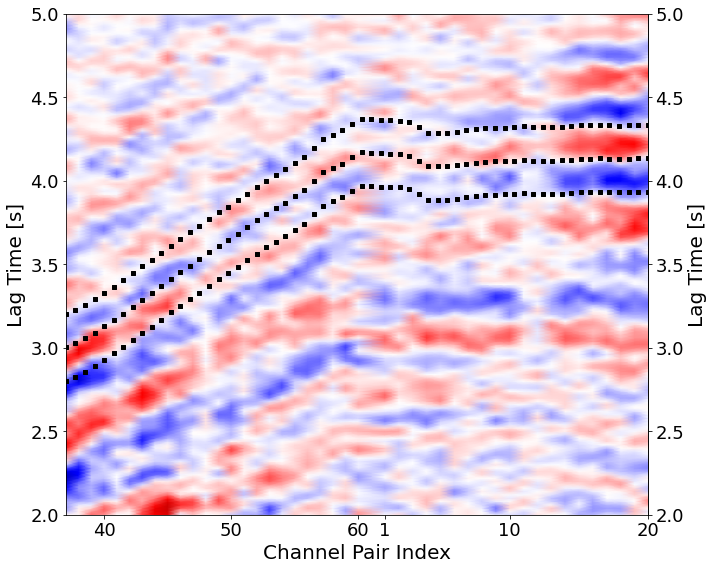

In [1277]:
### Zoom-in plot

clim = 2e-1
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(x_data, timestamp, np.flip(plot_gather[:,:].T, axis=0), vmin=-clim, vmax=clim, 
              cmap='seismic', shading='gouraud')
# ax.axvline(vline, linestyle='dashed', color='k', linewidth=2)
ax.set_xlim([0.6*vline, 1.3*vline])
ax.set_ylim([2, 5])
ax.set_ylabel('Lag Time [s]')
secax = ax.secondary_yaxis('right')
secax.set_ylabel('Lag Time [s]')

# Channel pair index
x1_index = np.array([40, 50, N1])
x2_index = np.array([1, 10, 20])

# Velocity indicators
# Case2: 225, 180
# Case3: 250, 180
vph_zoom, vg_zoom = 250, 180
ms_zoom = 20
x1_zoom = np.linspace(0.5*vline,1.0*vline,41)
x2_zoom = np.linspace(1.0*vline,1.5*vline,41)
offset2_zoom = interp_offset(x2_zoom)
doffset1_zoom = interp_offset(x1_zoom) - offset2_zoom[0]
reftime_zoom = offset2_zoom[0] / vg_zoom
ax.scatter(x1_zoom, reftime_zoom+doffset1_zoom/vph_zoom, s=ms_zoom, c='k', marker='s')
ax.scatter(x2_zoom, (offset2_zoom) / vg_zoom, s=ms_zoom, c='k', marker='s')
ax.scatter(x1_zoom, reftime_zoom+doffset1_zoom/vph_zoom+0.2, s=ms_zoom, c='k', marker='s')
ax.scatter(x2_zoom, (offset2_zoom) / vg_zoom+0.2, s=ms_zoom, c='k', marker='s')
ax.scatter(x1_zoom, reftime_zoom+doffset1_zoom/vph_zoom-0.2, s=ms_zoom, c='k', marker='s')
ax.scatter(x2_zoom, (offset2_zoom) / vg_zoom-0.2, s=ms_zoom, c='k', marker='s')

# ax.get_xaxis().set_visible(False)
ax.set_xticks(np.concatenate((x1_data[x1_index-1], x2_data[x2_index-1])), 
              np.concatenate((x1_index, x2_index)))
ax.set_xlabel('Channel Pair Index')

fig.tight_layout(pad=1.0)
plt.savefig('./profile_new/Ex3_zoom.png', dpi=300)

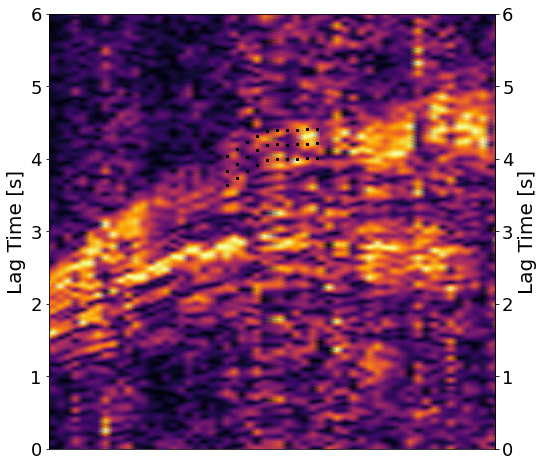

In [772]:
### Zoom-in plot

clim = 1
fig, ax = plt.subplots(figsize=(8,8))
ax.pcolormesh(x_data, timestamp, np.flip(plot_envelope[:,:].T, axis=0), vmin=0, vmax=clim, 
              cmap='inferno', shading='gouraud')
# ax.axvline(vline, linestyle='dashed', color='k', linewidth=2)
ax.set_xlim([0.5*vline, 1.5*vline])
ax.set_ylim([0, 6])
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Lag Time [s]')
secax = ax.secondary_yaxis('right')
secax.set_ylabel('Lag Time [s]')

# Velocity indicators
vel_zoom = 185
x_zoom = np.linspace(0.9*vline,1.1*vline,10)
offset_zoom = interp_offset(x_zoom)
ax.scatter(x_zoom, (offset_zoom) / vel_zoom + 0.4, s=5, c='k', marker='s')
ax.scatter(x_zoom, (offset_zoom) / vel_zoom + 0.2, s=5, c='k', marker='s')
ax.scatter(x_zoom, (offset_zoom) / vel_zoom + 0.0, s=5, c='k', marker='s')

Text(0.5, 0, 'Channel Pair Index')

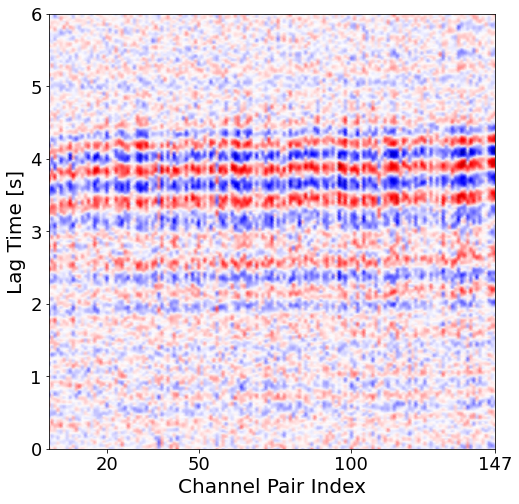

In [18]:
# One single profile

# plot_gather, plot_st = window_trace(timestamp, select_st, **window_param['L'])

clim = 2e-1
fig, ax = plt.subplots(figsize=(8,8))
ax.pcolormesh(x2_data, timestamp, np.flip(plot_gather[N1:,:].T, axis=0), vmin=-clim, vmax=clim, 
              cmap='seismic', shading='gouraud')
# ax.axvline(vline, linestyle='dashed', color='k', linewidth=2)
# ax.set_xlim([0.6*vline, 1.3*vline])
ax.set_ylim([0, 6])
ax.set_ylabel('Lag Time [s]')
ax.set_xlabel('Offset [m]')

x2_index = np.array([20, 50, 100, N2])
ax.set_xticks(x2_data[x2_index-1], x2_index)
ax.set_xlabel('Channel Pair Index')
# ax.get_xaxis().set_visible(False)

In [1282]:
def measure_amplitude(data):
    return np.max(data)
    # return np.sqrt(np.mean(data**2))

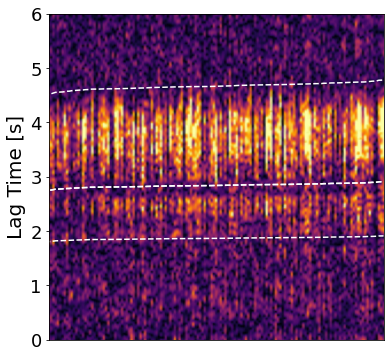

In [1297]:
### Right half

# Case 1:
# 0.5 - 10 Hz: 140, 230, 230, 350
# 1.5 - 3 Hz: 150, 220, 250, 400
# 3 - 6 Hz: 140, 180, 200, 270

# Case 2:
# 0.5 - 10 Hz: 140, 230, 230, 350
# 1.5 - 3 Hz: 150, 220, 220, 350
# 3 - 6 Hz: 140, 180, 200, 270

# Signals
parallel_gather = np.flip(plot_gather[N1:], axis=1)
parallel_envelope = np.flip(np.abs(signal.hilbert(plot_gather[N1:], axis=1)), axis=1)

vr = np.array([140, 230, 230, 350])

fig, ax = plt.subplots(figsize=(6,6))
ax.pcolormesh(x2_data, timestamp, parallel_envelope[:,:].T, vmin=0, vmax=0.1, 
               cmap='inferno', shading='gouraud')
ax.plot(x_data, ind_pair['Distance']/vr[0], 'w--')
ax.plot(x_data, ind_pair['Distance']/vr[1], 'w--')
ax.plot(x_data, ind_pair['Distance']/vr[2], 'w--')
ax.plot(x_data, ind_pair['Distance']/vr[3], 'w--')
ax.set_xlim([np.min(x2_data), np.max(x2_data)])
ax.set_ylim([0, 6])
ax.set_ylabel('Lag Time [s]')
ax.get_xaxis().set_visible(False)
plt.show()

In [1298]:
# Love wave amplitudes
amp_L = np.nan * np.ones((N2,))
for i in range(0,N2):
    dist_cur = ind_pair2['Distance'].iloc[i]
    mask_cur = (timestamp <= dist_cur/vr[0]) & (timestamp >= dist_cur/vr[1])
    amp_L[i] = measure_amplitude(parallel_gather[i][mask_cur])
    
# Order by Love amplitude
order_L = np.flip(np.argsort(amp_L))
    
# Rayleigh wave amplitudes
amp_R = np.nan * np.ones((N2,))
for i in range(0,N2):
    dist_cur = ind_pair2['Distance'].iloc[i]
    mask_cur = (timestamp <= dist_cur/vr[2]) & (timestamp >= dist_cur/vr[3])
    amp_R[i] = measure_amplitude(parallel_gather[i][mask_cur])

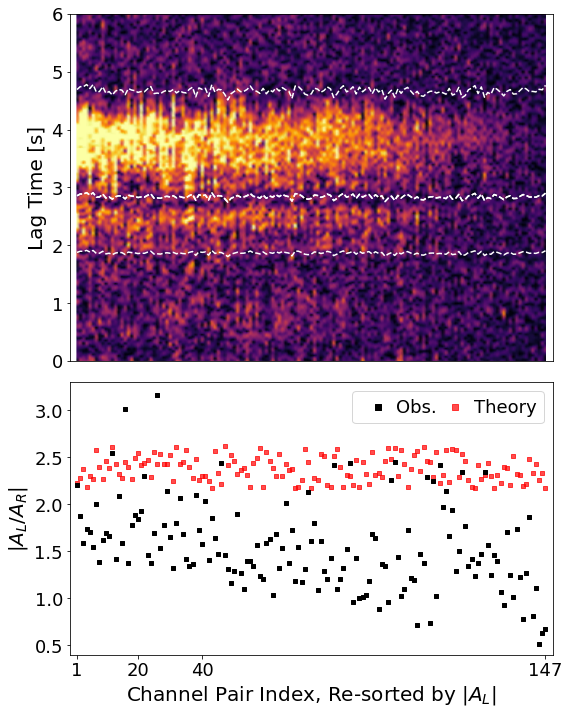

In [1299]:
# Channel pair index
x2_index = np.array([1, 20, 40, N2])

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 10),
                               gridspec_kw={'height_ratios': [1.4, 1.1]})
ax1.pcolormesh(x2_data, timestamp, parallel_envelope[order_L,:].T, vmin=0, vmax=0.1, 
               cmap='inferno', shading='gouraud')
ax1.plot(x2_data, ind_pair2['Distance'].iloc[order_L]/vr[0], 'w--')
ax1.plot(x2_data, ind_pair2['Distance'].iloc[order_L]/vr[1], 'w--')
ax1.plot(x2_data, ind_pair2['Distance'].iloc[order_L]/vr[2], 'w--')
ax1.plot(x2_data, ind_pair2['Distance'].iloc[order_L]/vr[3], 'w--')
ax1.set_ylim([0, 6])
ax1.set_ylabel('Lag Time [s]')
ax1.get_xaxis().set_visible(False)

ax2.scatter(x2_data, (amp_L/amp_R)[order_L], s=10, c='k', marker='s',zorder=10, label='Obs.')
ax2.scatter(x2_data, (ind_pair2['Love']/ind_pair2['Rayleigh']).to_numpy()[order_L], 
           s=10, c='r', marker='s', alpha=0.7, edgecolors=None, label='Theory')
ax2.set_ylabel('$|A_L/A_R|$')
ax2.set_ylim(0.4, 3.3)
ax2.set_xlim([np.min(x2_data)-0.015, np.max(x2_data)+0.015])
ax2.legend(ncol=2, columnspacing=0.05, handletextpad=0.01, markerscale=2, loc='upper right')

# ax2.get_xaxis().set_visible(False)
ax2.set_xticks(x2_data[x2_index-1], x2_index)
ax2.set_xlabel('Channel Pair Index, Re-sorted by $|A_L|$')

fig.tight_layout(pad=1.0)
# plt.savefig('./profile_new/AL_2.png', dpi=300)

# Group velocity measurement

In [1424]:
# Correct instantaneous frequency
# Group velocity dispersion

# Profile (Parallel)
# measure_ind_pair = ind_pair2.iloc[order_L,:]
# measure_offset = offset2
# measure_gather = select_gather[N1:,:]
# measure_st = gather_to_stream(measure_gather[order_L,:], measure_ind_pair)

# Profile (Oblique)
measure_ind_pair = ind_pair1
measure_offset = offset1
measure_gather = select_gather[:N1,:]
measure_st = select_st[:N1]

# Window function
# measure_gather, measure_st = window_trace(timestamp, measure_st, ref_vel=ref_vel_L, dv=40, taper=0.25)

# Range to analyze (Parallel)
# max_i = int(np.floor(0.75*len(measure_st))) # 111 for case 1
# measure_st = measure_st[:max_i]
# measure_gather = measure_gather[:max_i, :]
# measure_ind_pair = measure_ind_pair.iloc[:max_i,:]
# measure_offset = measure_offset[:max_i]

# Range to analyze (Oblique)
min_i = 30
measure_st = measure_st[min_i:]
measure_gather = measure_gather[min_i:, :]
measure_ind_pair = measure_ind_pair.iloc[min_i:,:]
measure_offset = measure_offset[min_i:]

# Frequency and velocity samples
vg_freqs = np.arange(filt_range[0], filt_range[1]+0.01, 0.02)
vg_samp = np.arange(100., 701., 1.)

# vg_freqs, cwt_map_p, cwt_map_n, coi_p, coi_n = stack_psd_correction(measure_st, measure_ind_pair, 
#                                                timestamp, vg_samp, filt_range, filt_range, 
#                                                vg_freqs.shape[0], None, smooth=False)
vg_freqs, cwt_map_p, cwt_map_n, coi_p, coi_n = stack_psd(measure_st, measure_ind_pair, timestamp, vg_samp,
                                                         filt_range, vg_freqs.shape[0], None)

# Group velocity
cwt_map_p = normfunc(cwt_map_p.T)
cwt_map_n = normfunc(cwt_map_n.T)
vg_p = extract_ridge(vg_freqs, vg_samp, cwt_map_p, None, 25)
vg_n = extract_ridge(vg_freqs, vg_samp, cwt_map_n, None, 25)
vg_ave = extract_ridge(vg_freqs, vg_samp, (cwt_map_p+cwt_map_n)/2, None, 25)

Maximum distance : 572.63 m
Minimum distance : 267.68 m
Average distance : 411.26 m
Median distance : 403.65 m


100%|██████████| 35/35 [00:12<00:00,  2.85it/s]


(-6.0, 6.0)

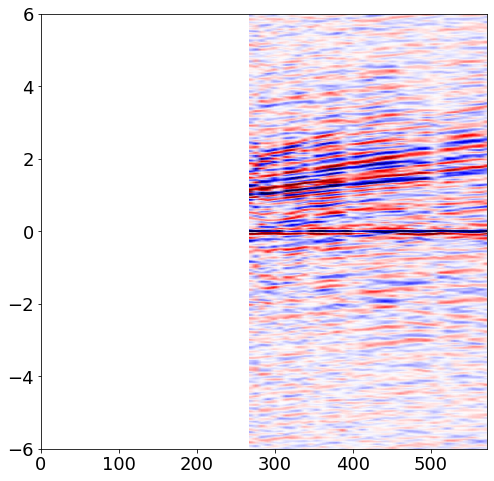

In [1425]:
clim = 2e-1
fig, ax = plt.subplots(figsize=(8,8))
ax.pcolormesh(measure_offset, timestamp, np.flip(measure_gather.T, axis=0), vmin=-clim, vmax=clim, 
               cmap='seismic', shading='gouraud')
ax.set_xlim([0, np.max(measure_offset)])
# ax.set_xlim([np.min(measure_offset), np.max(measure_offset)])
ax.set_ylim([-6, 6])

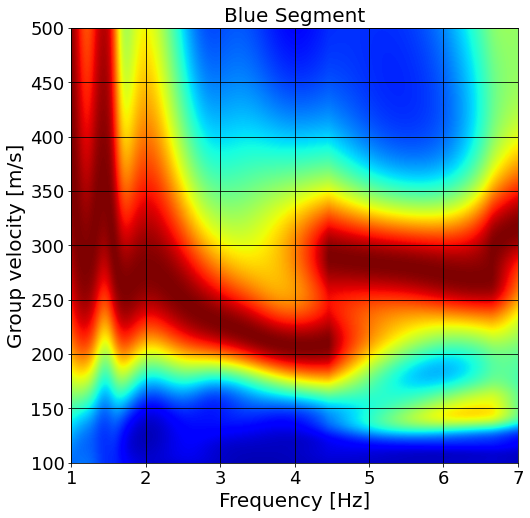

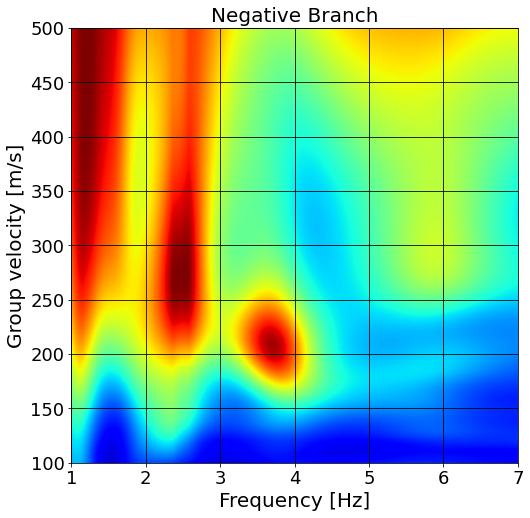

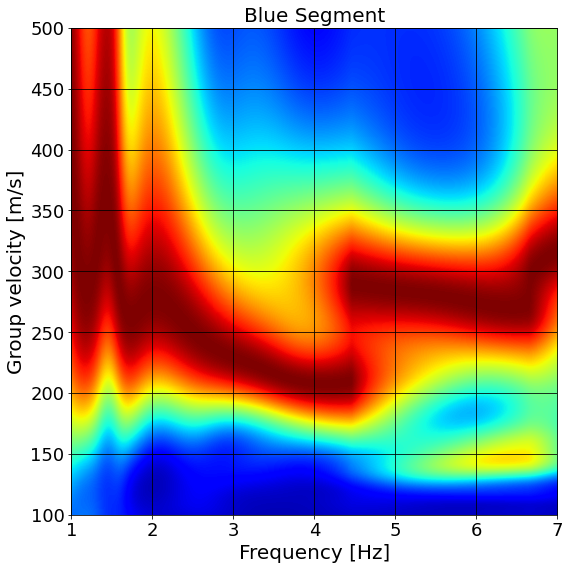

In [1427]:
# Plot group velocity dispersion

cr = [0, 1]
plt.figure(figsize=[8, 8])
plt.imshow(cwt_map_p, aspect='auto', vmin=cr[0], vmax=cr[1], cmap='jet', interpolation='bicubic', 
           extent=[vg_freqs[0], vg_freqs[-1], vg_samp[0], vg_samp[-1]], origin='lower')
# plt.scatter(vg_freqs, vg_p, color='w', s=20)
plt.grid(c='k')
plt.xlim([1, 7])
plt.ylim([100, 500])
plt.xlabel('Frequency [Hz]')
# plt.axhline(175, color='w')
plt.ylabel('Group velocity [m/s]')
plt.title('Blue Segment')
# plt.xlim(filt_range)
plt.show()

plt.figure(figsize=[8, 8])
plt.imshow(cwt_map_n, aspect='auto', vmin=cr[0], vmax=cr[1], cmap='jet', interpolation='bicubic', 
           extent=[vg_freqs[0], vg_freqs[-1], vg_samp[0], vg_samp[-1]], origin='lower')
plt.grid(c='k')
plt.xlim([1, 7])
plt.ylim([100, 500])
plt.xlabel('Frequency [Hz]')
# plt.xlim(filt_range)
# plt.axhline(175, color='w')
plt.ylabel('Group velocity [m/s]')
plt.title('Negative Branch')
plt.show()

plt.figure(figsize=[8, 8])
plt.imshow((cwt_map_p+cwt_map_n)/2, aspect='auto', vmin=cr[0], vmax=cr[1], cmap='jet', interpolation='bicubic', 
           extent=[vg_freqs[0], vg_freqs[-1], vg_samp[0], vg_samp[-1]], origin='lower')
# plt.scatter(vg_freqs, vg_ave, color='w', s=20)
# plt.scatter(vg_freqs, vg_p, color='k', s=20)
plt.grid(c='k')
plt.xlim([1, 7])
plt.ylim([100, 500])
plt.xlabel('Frequency [Hz]')
# plt.xlim(filt_range)
# plt.axhline(175, color='w')
plt.ylabel('Group velocity [m/s]')
plt.title('Blue Segment')
plt.tight_layout(pad=1.0)
# plt.savefig('./disp_map_new/Rayleigh_group_blue.png', dpi=300)
plt.show()

In [1310]:
# np.savez('./disp_map_new/love_group_0_correction.npz', freqs=vg_freqs, vels=vg_samp, cwt_map=cwt_map_p)

# Phase velocity

In [1396]:
# Profile
min_i = 0
measure_ind_pair = ind_pair.iloc[min_i:N1, :]
measure_gather = select_gather[min_i:N1,:]
measure_offset = offset1[min_i:N1]
measure_st = select_st[min_i:N1]

# Window function
measure_gather, _ = window_trace(timestamp, measure_st, **window_param['R'])
# measure_gather, _ = window_trace(timestamp, measure_st, ref_vel=280, dv=50, min_win=0, taper=0.25) # Case 2: Rayleigh
# measure_gather, _ = window_trace(timestamp, measure_st, ref_vel=160, dv=20, min_win=0, taper=0.25) # Case 2: Love
# measure_gather, _ = window_trace(timestamp, measure_st, ref_vel=160, dv=30, min_win=0.3, taper=0.25) # Case 2: Final

# Frequency and velocity samples
vph_freqs = np.arange(filt_range[0], filt_range[1]+0.01, 0.02)
vph_samp = np.arange(100., 701., 1.)

# Phase velocity dispersion
fv_map_p = calc_vph_disp(measure_gather, measure_offset, vph_freqs, vph_samp, pos=True)
fv_map_n = calc_vph_disp(measure_gather, measure_offset, vph_freqs, vph_samp, pos=False)

# Phase velocity
fv_map_p = normfunc(fv_map_p)
fv_map_n = normfunc(fv_map_n)
vph_p = extract_ridge(vph_freqs, np.flip(vph_samp), fv_map_p, None, 25)
vph_n = extract_ridge(vph_freqs, np.flip(vph_samp), fv_map_n, None, 25)

# Measure at specific frequency samples
measure_range = [3.0, 6.5]  #[1.5, 6.0]
freq_samples = np.arange(measure_range[0], measure_range[1]+0.1, 0.2)
vph_freq_samp, vph_mean, vph_min, vph_max = measure_disp_plot(vph_freqs, vph_samp, 
                                                              np.flip((fv_map_p+fv_map_n)/2, axis=0), freq_samples)
                                                              # func_vel=(lambda x: 380), vel_offset=100)


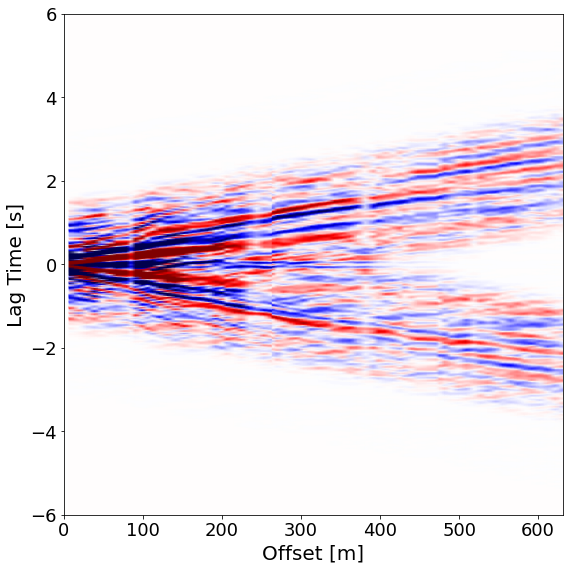

In [1397]:
clim = 2e-1
fig, ax = plt.subplots(figsize=(8,8))
ax.pcolormesh(measure_offset, timestamp, np.flip(measure_gather[:,:].T, axis=0), vmin=-clim, vmax=clim, 
               cmap='seismic', shading='gouraud')
ax.set_xlim([0, np.max(measure_offset)])
ax.set_ylim([-6, 6])
ax.set_xlabel('Offset [m]')
ax.set_ylabel('Lag Time [s]')
plt.tight_layout(pad=1.0)
plt.savefig('./disp_map_new/profile_Rayleigh_1.png', dpi=300)

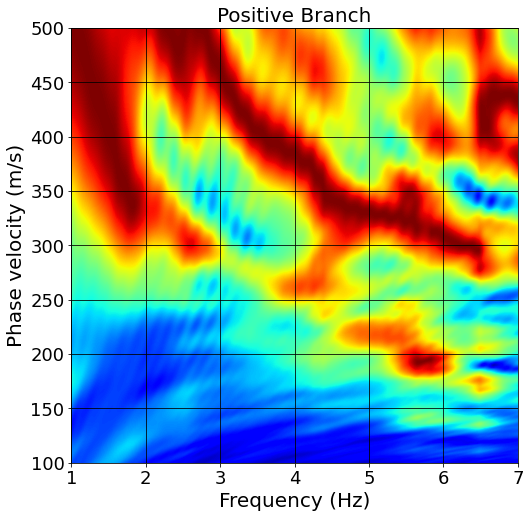

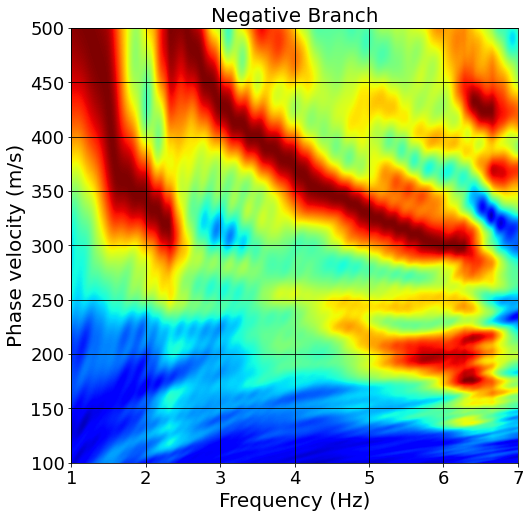

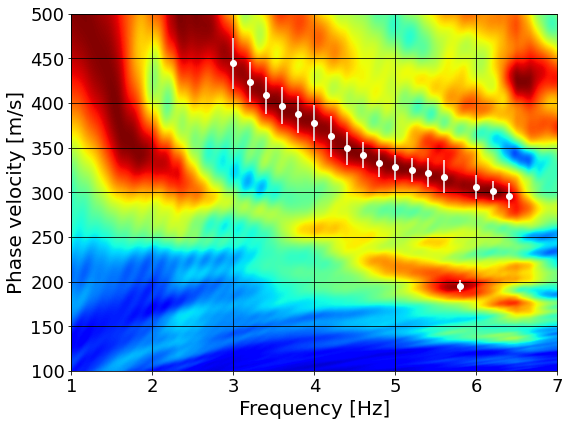

In [1398]:
# Plot phase velocity dispersion

clim = 1
plt.figure(figsize=[8, 8])
plt.imshow(fv_map_p, aspect='auto', vmin=0, vmax=clim, cmap='jet', interpolation='bicubic', 
           extent=[vph_freqs[0], vph_freqs[-1], vph_samp[0], vph_samp[-1]], origin='upper')
# plt.scatter(vph_freqs, vph_p, color='w', s=20)
plt.grid(c='k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.xlim([1, 7])
plt.ylim([100, 500])
plt.title('Positive Branch')
plt.show()

plt.figure(figsize=[8, 8])
plt.imshow(fv_map_n, aspect='auto', vmin=0, vmax=clim, cmap='jet', interpolation='bicubic', 
           extent=[vph_freqs[0], vph_freqs[-1], vph_samp[0], vph_samp[-1]], origin='upper')
# plt.scatter(vph_freqs, vph_n, color='w', s=20)
plt.grid(c='k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.xlim([1, 7])
plt.ylim([100, 500])
plt.title('Negative Branch')
plt.show()

plt.figure(figsize=[8, 6])
plt.imshow((fv_map_p+fv_map_n)/2, aspect='auto', vmin=0, vmax=clim, cmap='jet', interpolation='bicubic', 
           extent=[vph_freqs[0], vph_freqs[-1], vph_samp[0], vph_samp[-1]], origin='upper')
plt.errorbar(vph_freq_samp, (vph_max+vph_min)/2, yerr=np.abs(np.stack((vph_min, vph_max))-(vph_max+vph_min)/2), 
             fmt='o', color='w')
plt.grid(c='k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase velocity [m/s]')
plt.xlim([1, 7])
plt.ylim([100, 500])
# plt.title('Average of Two Branches')
plt.tight_layout(pad=1.0)
# plt.savefig('./disp_map_new/phase_slow.png', dpi=300)
plt.show()

In [1356]:
# np.savez('./disp_map_new/love_phase_0.npz', freqs=vph_freqs, vels=vph_samp, fv_map=(fv_map_p+fv_map_n)/2)

# Window function

In [1462]:
tr = Trace(data=np.ones(timestamp.shape))
tr.stats.delta = dt
tr.stats.starttime = UTCDateTime(2000, 1, 1, 0, 0, 0)
tr.stats.distance = 400
test_st = Stream(tr)
test_gather, _ = window_trace(timestamp, test_st, ref_vel=200, dv=0, min_win=0.5, taper=0.25)

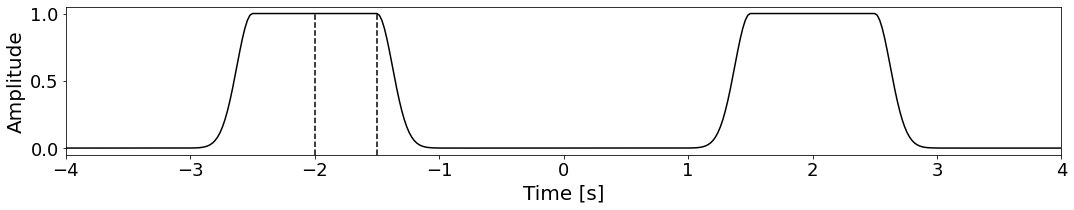

In [1470]:
fig, ax = plt.subplots(1, figsize=(15,3))
ax.plot(timestamp, test_gather[0], 'k-')
ax.set_xlim([-4, 4])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
plt.tight_layout(pad=1.0)
ax.plot([-2,-2], [-0.05,1], 'k--')
ax.plot([-1.5,-1.5], [-0.05,1], 'k--')
# plt.savefig('./disp_map_new/window.png', dpi=300)
plt.show()

# Read measurements

In [700]:
# Reference Love wave group velocity
ref_vg_freq = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
ref_vg = np.array([225, 180, 160, 150, 150, 150])

func_vg = interp1d(ref_vg_freq, ref_vg, fill_value="extrapolate")

In [1357]:
# Read data
fv_data = np.load('./disp_map_new/love_phase_0.npz')

# Measure dispersion at specific frequencies
measure_range = [1.5, 5.5]
freq_samples = np.arange(measure_range[0], measure_range[1]+0.1, 0.2)

vph_freq_samp, vph_mean, vph_min, vph_max = measure_disp_plot(fv_data['freqs'], fv_data['vels'], 
                                                              np.flip(fv_data['fv_map'], axis=0), freq_samples)
                                                              # func_vel=lambda x: 375, vel_offset=120)
# vg_freq_samp, vg_mean, vg_min, vg_max = measure_disp_plot(fv_data['freqs'], fv_data['vels'], 
#                                                           fv_data['cwt_map'], freq_samples,
#                                                           func_vel=func_vg, vel_offset=20)

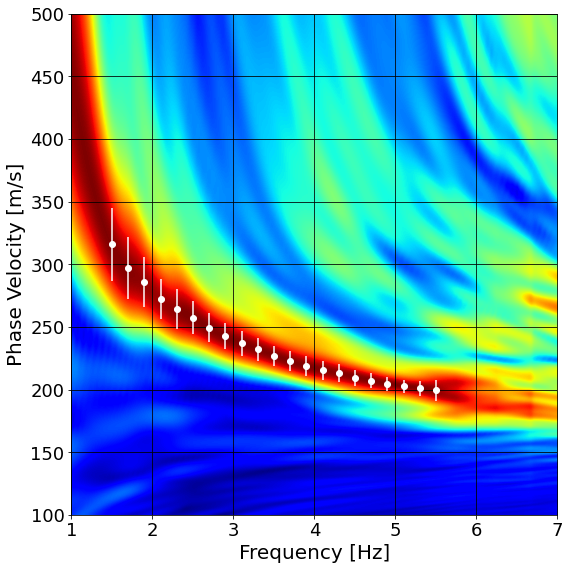

In [1364]:
# Plot phase velocity dispersion

clim = 1
plt.figure(figsize=[8, 8])
plt.imshow(fv_data['fv_map'], aspect='auto', vmin=0, vmax=clim, cmap='jet', interpolation='bicubic', 
           extent=[fv_data['freqs'][0], fv_data['freqs'][-1], fv_data['vels'][0], fv_data['vels'][-1]], 
           origin='upper')
# plt.errorbar(vph_freq_samp, (vph_max+vph_min)/2, yerr=np.abs(np.stack((vph_min, vph_max))-(vph_max+vph_min)/2), 
#              fmt='o', color='w')
plot_curve(curve1, color='w')
# plot_curve(curve3, color='0.4')
# plot_curve(curve4, color='0.4')
plt.grid(c='k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase Velocity [m/s]')
plt.xlim([1.0, 7.0])
plt.ylim([100, 500])
plt.tight_layout(pad=1.0)
# plt.savefig('./disp_map_new/love_phase_0.png', dpi=300)

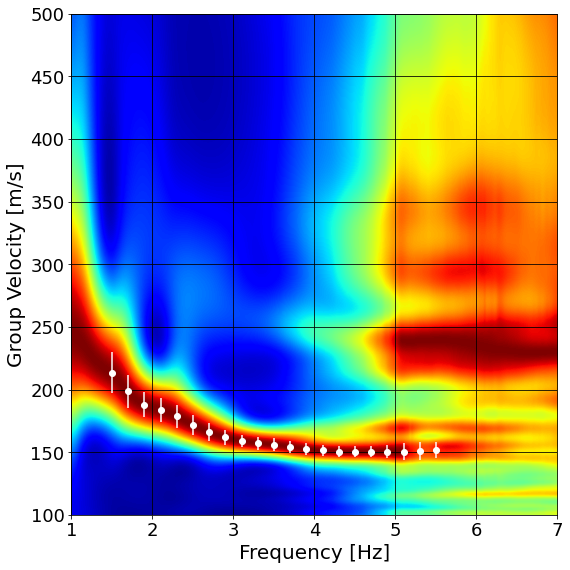

In [1320]:
# Plot group velocity dispersion

cr = [0, 1]
plt.figure(figsize=[8, 8])
plt.imshow(fv_data['cwt_map'], aspect='auto', vmin=cr[0], vmax=cr[1], cmap='jet', interpolation='bicubic', 
           extent=[fv_data['freqs'][0], fv_data['freqs'][-1], fv_data['vels'][0], fv_data['vels'][-1]], 
           origin='lower')
# plt.errorbar(vg_freq_samp, (vg_max+vg_min)/2, yerr=np.abs(np.stack((vg_min, vg_max))-(vg_max+vg_min)/2), 
#              fmt='o', color='w')
plot_curve(curve2, color='w')
plt.grid(c='k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group Velocity [m/s]')
plt.xlim([1.0, 7.0])
plt.ylim([100, 500])
plt.tight_layout(pad=1.0)
# plt.savefig('./disp_map_new/love_group_0.png', dpi=300)

In [719]:
# 1 - parallel pairs, case 1
# 2 - parallel pairs, case 2
# 3 - oblique pairs, case 2
# 4 - oblique pairs, case 3

# vg_freq_4 = vg_freq_samp.copy()
# vg_mean_4 = (vg_max+vg_min)/2
# vg_err_4 = np.abs(np.stack((vg_min, vg_max))-(vg_max+vg_min)/2)

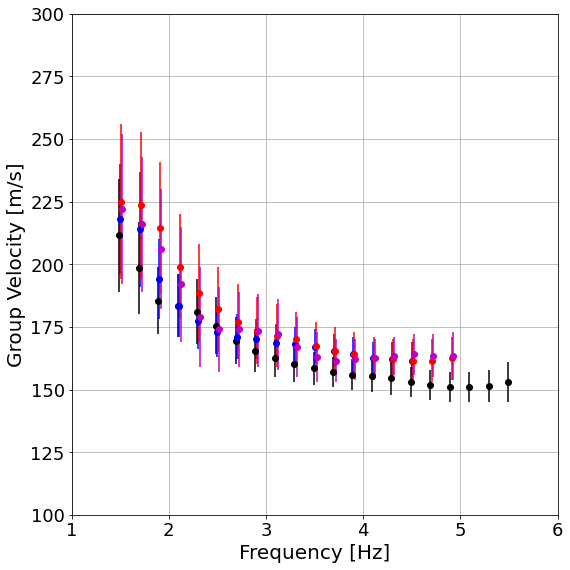

In [722]:
plt.figure(figsize=[8, 8])
plt.errorbar(vg_freq_1-0.01, vg_mean_1, yerr=vg_err_1, fmt='o', color='k')
plt.errorbar(vg_freq_2, vg_mean_2, yerr=vg_err_2, fmt='o', color='b')
plt.errorbar(vg_freq_3+0.01, vg_mean_3, yerr=vg_err_3, fmt='o', color='r')
plt.errorbar(vg_freq_4+0.02, vg_mean_4, yerr=vg_err_4, fmt='o', color='m')
plt.grid()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group Velocity [m/s]')
plt.xlim([1.0, 6])
plt.ylim([100, 300])
plt.tight_layout(pad=1.0)
# plt.savefig('./disp_map_new/love_group_all.png', dpi=300)

In [1361]:
# Record measurements

# curve1 = Curve(1/vph_freq_samp, (vph_max+vph_min)/2e3, 0, "love", "phase", weight=1.0, uncertainties=(vph_max-vph_min)/2e3)
# curve2 = Curve(1/vg_freq_samp, (vg_max+vg_min)/2e3, 0, "love", "group", weight=1.0, uncertainties=(vg_max-vg_min)/2e3)
# curve3 = Curve(1/vph_freq_samp, (vph_max+vph_min)/2e3, 0, "rayleigh", "phase", weight=1.0, uncertainties=(vph_max-vph_min)/2e3)
# curve4 = Curve(1/vph_freq_samp, (vph_max+vph_min)/2e3, 1, "rayleigh", "phase", weight=1.0, uncertainties=(vph_max-vph_min)/2e3)


# Inversion

In [19]:
from evodcinv import EarthModel, Layer, Curve
from matplotlib.cm import ScalarMappable

from matplotlib.colors import ListedColormap
from matplotlib import cm

# Model from Hayashi & Burns (2020)
hayashi_model = {'Depth':np.array([0, 10.0, 10.0, 37.2, 37.2, 81.1, 81.1, 270.3, 270.3, 1000])/1e3, \
                 'Vs':np.array([88.9, 88.9, 233.3, 233.3, 322.2, 322.2, 588.9, 588.9, 900, 900])/1e3}

In [20]:
# Functions
def save_curves(curve1, curve2, curve3, curve4, filename='curves.npz'):
    
    L_phase = np.vstack((curve1.period, curve1.data, curve1.uncertainties))
    L_group = np.vstack((curve2.period, curve2.data, curve2.uncertainties))
    R_phase_0 = np.vstack((curve3.period, curve3.data, curve3.uncertainties))
    R_phase_1 = np.vstack((curve4.period, curve4.data, curve4.uncertainties))
    
    np.savez(os.path.join('./inversion_new/', filename), L_phase=L_phase, L_group=L_group, 
             R_phase_0=R_phase_0, R_phase_1=R_phase_1)
    

def read_curves(filename='curves.npz'):
    
    curve_data = np.load(os.path.join('./inversion_new/', filename))
    curve1 = Curve(curve_data['L_phase'][0], curve_data['L_phase'][1], 0, "love", "phase", 
                   weight=1.0, uncertainties=curve_data['L_phase'][2])
    curve2 = Curve(curve_data['L_group'][0], curve_data['L_group'][1], 0, "love", "group", 
                   weight=1.0, uncertainties=curve_data['L_group'][2])
    curve3 = Curve(curve_data['R_phase_0'][0], curve_data['R_phase_0'][1], 0, "rayleigh", "phase",
                   weight=1.0, uncertainties=curve_data['R_phase_0'][2])
    curve4 = Curve(curve_data['R_phase_1'][0], curve_data['R_phase_1'][1], 1, "rayleigh", "phase",
                   weight=1.0, uncertainties=curve_data['R_phase_1'][2])
    
    return curve1, curve2, curve3, curve4


def plot_curve(curve, xlabel='freq', color='k', scale=1e3):
    
    if xlabel == 'freq':
        if curve.uncertainties is None:
            plt.scatter(1/curve.period, curve.data*scale, color=color)
        else:
            plt.errorbar(1/curve.period, curve.data*scale, yerr=curve.uncertainties*scale, fmt='o', color=color)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Velocity [m/s]')
        
    elif xlabel == 'period':
        if curve.uncertainties is None:
            plt.scatter(curve.period, curve.data*scale, color=color)
        else:
            plt.errorbar(curve.period, curve.data*scale, yerr=curve.uncertainties*scale, fmt='o', color=color)
        plt.xlabel('Period [s]')
        plt.ylabel('Velocity [m/s]')

In [21]:
from disba import Ellipticity, depthplot, resample, surf96
from disba._common import ifunc
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from joblib import Parallel, delayed

def plot_predicted_curve(inv_result, period, mode, wave, type, show="best", stride=1, percent=10, 
                         plot_args=None, ax=None):
    
    if type not in {"phase", "group", "ellipticity"}:
        raise ValueError()
    
    # Default parameters
    n_jobs = -1
    dc = 0.001
    dt = 0.01
    itype = {"phase": 0, "group": 1}
    units = {"frequency": "Hz", "period": "s"}
    
    # Model dispersion curves
    def get_y(thickness, velocity_p, velocity_s, density):
        c = surf96(period, thickness, velocity_p, velocity_s, density, mode, 
                   itype[type], ifunc["dunkin"][wave], dc, dt)
        idx = c > 0.0
        return c[idx]
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"type": "line", "xaxis": "period", "yaxis": "velocity", "cmap": "Oranges_r"}
    _plot_args.update(plot_args)

    plot_type = _plot_args.pop("type")
    xaxis = _plot_args.pop("xaxis")
    yaxis = _plot_args.pop("yaxis")
    cmap = _plot_args.pop("cmap")
    
    plot_type = plot_type if plot_type != "line" else "plot"
    plot = getattr(plt if ax is None else ax, plot_type)
    x = 1.0 / period if xaxis == "frequency" else period
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot curves from %d models.' %misfits.shape[0])

        # Make colormap
        norm = Normalize(misfits.min(), misfits.max())
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Generate and plot curves
        curves = Parallel(n_jobs=n_jobs)(delayed(get_y)(*model.T) for model in models)
        for curve, misfit in zip(curves, misfits):
            y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
            plot(x[: len(y)], y, color=smap.to_rgba(misfit), **_plot_args)

    elif show == "best":
        curve = get_y(*inv_result.model.T)
        y = y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
        plot(x[: len(y)], y, **_plot_args)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()

    xlabel = f"{xaxis.capitalize()} [{units[xaxis]}]"
    ylabel = f"{type.capitalize()} "
    ylabel += f"{yaxis} [m/s]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)

    # Disable exponential tick labels
    gca.xaxis.set_major_formatter(ScalarFormatter())
    gca.xaxis.set_minor_formatter(ScalarFormatter())
    
    
def plot_model(inv_result, parameter, show="best", stride=1, percent=10, zmax=None, 
               plot_args=None, ax=None, cmap_on=False, cmap_args=None, cmap_range=None):
    
    parameters = {
            "velocity_p": 1,
            "velocity_s": 2,
            "density": 3,
            "vp": 1,
            "vs": 2,
            "rho": 3,
    }
    
    if parameter not in parameters:
        raise ValueError()
    i_param = parameters[parameter]
        
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"cmap": "gist_ncar", "color": "black", "linewidth": 2}
    _plot_args.update(plot_args)

    cmap = _plot_args.pop("cmap")
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot %d models.' %misfits.shape[0])

        # Make colormap
        if cmap_range is None:
            norm = Normalize(misfits.min(), misfits.max())
        else:
            norm = Normalize(cmap_range[0], cmap_range[1])
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Plot models
        for model, misfit in zip(models, misfits):
            tmp = {k: v for k, v in _plot_args.items()}
            tmp["color"] = smap.to_rgba(misfit)
            depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=tmp, ax=ax)

    elif show == "best":
        model = inv_result.model
        depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    elif show == "mean":
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[:n_select+1]
        print('Plot mean of %d models.' %models.shape[0])
        print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))
        
        # Plot mean model
        model_mean = np.squeeze(np.mean(models, axis=0))
        depthplot(model_mean[:, 0]*1e3, model_mean[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()
    labels = {
        "velocity_p": "P-wave velocity [m/s]",
        "velocity_s": "S-wave velocity [m/s]",
        "density": "Density [$kg/m^3$]",
        "vp": "$V_p$ [m/s]",
        "vs": "$V_s$ [m/s]",
        "rho": "$\\rho$ [$kg/m^3$]",
    }
    xlabel = labels[parameter]
    ylabel = "Depth [m]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)
    
    # Colorbar
    if cmap_on:
        cmap_args = cmap_args if cmap_args is not None else {}
        _cmap_args = {"orientation": "vertical", "label": "Log Misfit", "location": "right"}
        _cmap_args.update(cmap_args)
        plt.colorbar(smap, **_cmap_args)
        
        
def plot_model_range(model, plot_args=None, ax=None):
    
    d1 = np.array([])
    vs1 = np.array([])
    d2 = np.array([])
    vs2 = np.array([])
    
    for layer in model.layers:
        d1 = np.append(d1, layer.thickness[1])
        vs1 = np.append(vs1, layer.velocity_s[0])
        d2 = np.append(d2, layer.thickness[0])
        vs2 = np.append(vs2, layer.velocity_s[1])
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"color": "black", "linewidth": 2}
    _plot_args.update(plot_args)
    
    d2[-1] = np.sum(d1) - np.sum(d2[:-1])
    depthplot(d1*1e3, vs1*1e3, None, plot_args=_plot_args, ax=ax)
    depthplot(d2*1e3, vs2*1e3, None, plot_args=_plot_args, ax=ax)
    

def model_param_range(inv_result, percent=30, stride=None, plot_nu=False):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.xs[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    if stride is None:
        stride = int(n_select // 4)
    models = models[n_select::-stride]
    n_model = models.shape[0]
    print('Record %d models.' %n_model)
    
    # Model parameters
    n_layer = int((len(models[0])+1) // 3)
    h = np.percentile(models[:, :n_layer-1], [0,25,50,75,100], axis=0)
    vs = np.percentile(models[:, n_layer-1:2*n_layer-1], [0,25,50,75,100], axis=0)
    nu = np.percentile(models[:, 2*n_layer-1:], [0,25,50,75,100], axis=0)
    
    # Print 0, 25, 50, 75, 100 percentiles
    for i in range(n_layer):
        print('Layer %d' %i)
        if i < n_layer - 1:
            print('Thickness [km]: %.4f, %.4f, %.4f, %.4f %.4f' %(h[0,i], h[1,i], h[2,i], h[3,i], h[-1,i]))
        print('Vs [km/s]: %.4f, %.4f, %.4f, %.4f %.4f' %(vs[0,i], vs[1,i], vs[2,i], vs[3,i], vs[-1,i]))
        print('Nu: %.4f, %.4f, %.4f, %.4f %.4f' %(nu[0,i], nu[1,i], nu[2,i], nu[3,i], nu[-1,i]))
        print()

    if plot_nu:
        nu = models[n_select::-1, 2*n_layer-1:]
        for i in range(n_layer):
            plt.figure(figsize=(8,8))
            plt.hist(nu[:, i])
            plt.grid()
            plt.show()
        

def get_mean_model(inv_result, percent=30):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.models[idx]
    misfits = inv_result.misfits[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    models = models[:n_select+1]
    print('Get mean of %d models.' %models.shape[0])
    print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))

    # Return mean model
    model_mean = np.squeeze(np.mean(models, axis=0))
    return model_mean

In [22]:
# save_curves(curve1, curve2, curve3, curve4)
curve1, curve2, curve3, curve4 = read_curves()

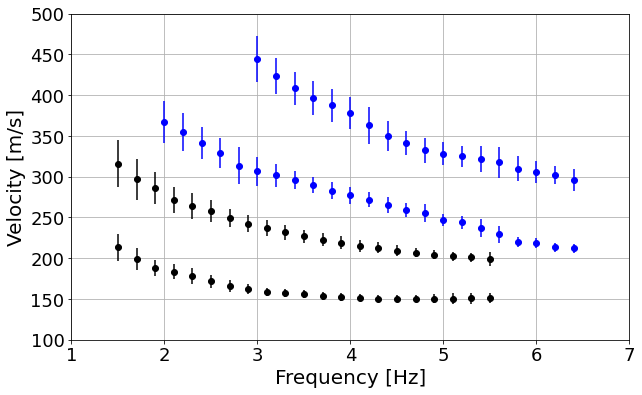

In [23]:
plt.figure(figsize=(10, 6))
plot_curve(curve1, color='k')
plot_curve(curve2, color='k')
plot_curve(curve3, color='b')
plot_curve(curve4, color='b')
plt.xlim([1, 7.0])
plt.ylim([100, 500])
plt.grid()

In [31]:
# Initialize model
model = EarthModel()

# Surface wave type

# Build model search boundaries from top to bottom
# First argument is the bounds of layer's thickness [km]
# Second argument is the bounds of layer's S-wave velocity [km/s]
# Third argument is the bounds of layer's Poisson ratio (default: 0.2-0.4)

# First manuscript
# model.add(Layer([0.005, 0.015], [0.05, 0.3], [0.3, 0.49]))
# model.add(Layer([0.005, 0.025], [0.05, 0.5], [0.3, 0.49]))
# model.add(Layer([0.02, 0.08], [0.2, 0.8], [0.3, 0.49]))
# model.add(Layer([0.02, 0.1], [0.4, 1.0], [0.2, 0.49]))

# Second manuscript
model.add(Layer([0.005, 0.015], [0.05, 0.3], [0.492, 0.492]))
model.add(Layer([0.005, 0.025], [0.05, 0.5], [0.492, 0.492]))
model.add(Layer([0.02, 0.06], [0.2, 0.8], [0.485, 0.485]))
model.add(Layer([0.02, 0.1], [0.4, 1.0], [0.45, 0.45]))

# Density model
f_rho = lambda x: 1.56 + 0.186*x

# Configure model
model.configure(
    optimizer = "cpso",  # Evolutionary algorithm
    misfit = "norm2",  # Misfit function type (e.g. rmse)
    density = f_rho,  # "nafe-drake"
    optimizer_args = {
        "popsize": 50,  # Population size
        "maxiter": 1000,  # Number of iterations
        "workers": -1,  # Number of cores    
        "seed": None, # Seed: 439(used)
    },
)

# curve2._weight = 1.0
# curves = [curve1, curve2]
curves = [curve1, curve2, curve3, curve4]

In [32]:
# Run inversion
res = model.invert(curves, maxrun=20)
print(res)

Run 1   |████████████████████| 100% [0:00:41 / 0:00:00] - Misfit: 6.8380  
Run 2   |████████████████████| 100% [0:00:45 / 0:00:00] - Misfit: 6.8259  
Run 3   |████████████████████| 100% [0:00:42 / 0:00:00] - Misfit: 6.8243  
Run 4   |████████████████████| 100% [0:00:42 / 0:00:00] - Misfit: 7.4288  
Run 5   |████████████████████| 100% [0:00:42 / 0:00:00] - Misfit: 6.8313  
Run 6   |████████████████████| 100% [0:00:40 / 0:00:00] - Misfit: 6.8356  
Run 7   |████████████████████| 100% [0:00:42 / 0:00:00] - Misfit: 6.8335  
Run 8   |████████████████████| 100% [0:00:44 / 0:00:00] - Misfit: 7.4257  
Run 9   |████████████████████| 100% [0:00:45 / 0:00:00] - Misfit: 6.8550  
Run 10  |████████████████████| 100% [0:00:41 / 0:00:00] - Misfit: 6.8419  
Run 11  |████████████████████| 100% [0:00:41 / 0:00:00] - Misfit: 6.8298  
Run 12  |████████████████████| 100% [0:00:43 / 0:00:00] - Misfit: 6.8331  
Run 13  |████████████████████| 100% [0:00:45 / 0:00:00] - Misfit: 7.4127  
Run 14  |████████████████

--------------------------------------------------------------------------------
Best model out of 1000000 models (20 runs)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0087    1.2626    0.1584    1.7948              0.0087    0.1584    0.4920
    0.0109    1.7931    0.2250    1.8935              0.0109    0.2250    0.4920
    0.0415    1.8801    0.3209    1.9097              0.0415    0.3209    0.4850
    1.0000    1.5844    0.4777    1.8547                   -    0.4777    0.4500
----------------------------------------          ------------------------------

Number of layers: 4
Number of parameters: 11
Best model misfit: 6.8204
-------

In [33]:
mask = np.isfinite(res.misfits)
res.misfits[~mask] = res.misfits[mask].max()
res.misfits = np.log10(res.misfits)

In [34]:
cmap = cm.get_cmap('gnuplot2')
cmap = ListedColormap(cmap(np.linspace(0.1, 0.9, 256)))

cmap = cm.get_cmap('gray')
cmap = ListedColormap(cmap(np.linspace(0, 0.9, 256)))

Plot 10000 models.
Plot mean of 300001 models.
Misfit range: 0.8338, 0.8709.


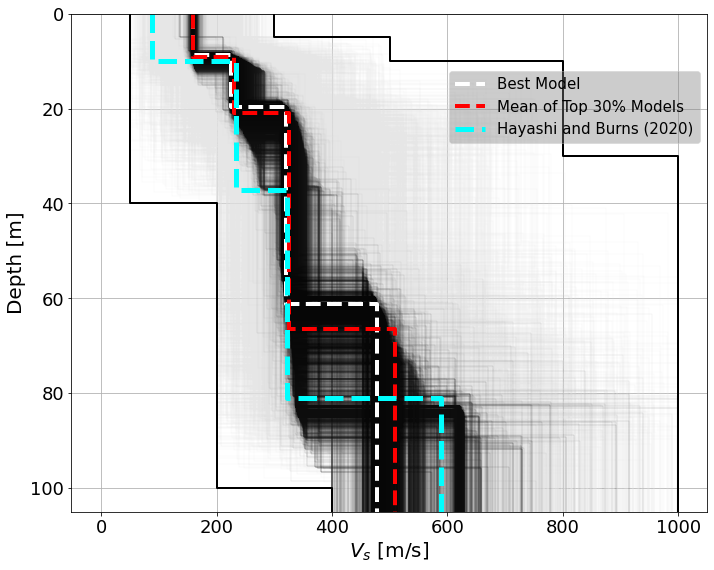

In [35]:
# Colormap: YlGnBu_r, winter

param = 'vs'
show = 'percentage'
percent = 100
stride = 100
cmap_range = (0.8, 2) # (-0.2, 1.5), (0.8, 2)

fig, ax = plt.subplots(figsize=(10,8))
ax.grid()
plot_model(res, param, show=show, stride=stride, percent=percent, 
           plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
           cmap_on=True, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)
plot_model(res, param, show='best', plot_args={"color":"white", "linewidth":4, "linestyle":"--"})
plot_model(res, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})
plot_model_range(model, ax=ax)
obj3, = ax.plot(hayashi_model['Vs']*1e3, hayashi_model['Depth']*1e3, linestyle='--', color='cyan', 
                linewidth=5, alpha=1, label='Hayashi and Burns (2020)')

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'w--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2, obj3], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))

ax.set_ylim([105, 0])
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_models_ND.png', dpi=300)

Plot curves from 151 models.
Plot curves from 151 models.
Plot curves from 151 models.
Plot curves from 151 models.


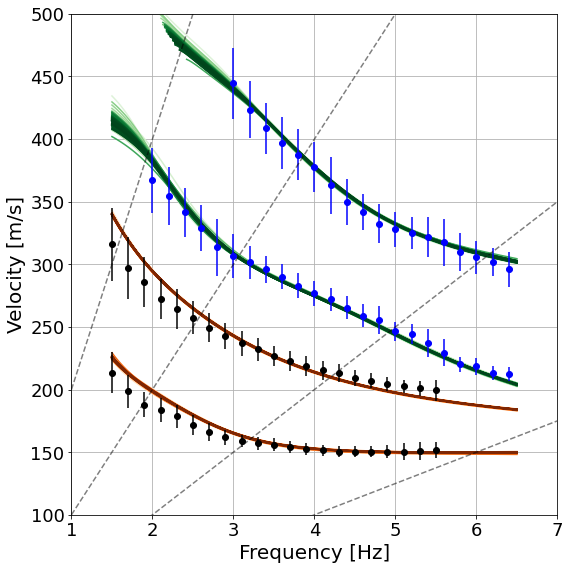

In [29]:
# Plot dispersion curves

show = 'percentage'
percent = 30
stride = 2000

fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 0, 'love', 'phase', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency"})
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 0, 'love', 'group', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency"})
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 0, 'rayleigh', 'phase', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 1, 'rayleigh', 'phase', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
# plot_predicted_curve(res, np.linspace(1/6, 1/1.5, 100), 0, 'rayleigh', 'group', show=show, percent=percent, 
#                      ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Oranges_r'})
# plot_predicted_curve(res, np.linspace(1/6, 1/1.5, 100), 1, 'rayleigh', 'group', show=show, percent=percent, 
#                      ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Oranges_r'})
plot_curve(curve1)
plot_curve(curve2)
plot_curve(curve3, color='b')
plot_curve(curve4, color='b')

# Plot reference wavelength
f_samp = np.linspace(1, 7, 100)
for wavelength in [25, 50, 100, 200]:
    plt.plot(f_samp, wavelength*f_samp, linestyle='--', color='k', alpha=0.5)
    
ax.set_ylabel('Velocity [m/s]')
ax.set_xlim([1, 7.0])
ax.set_ylim([100, 500])
plt.tight_layout(pad=1.0)
# plt.show()
# plt.savefig('./inversion_new/inv_curves_R.png', dpi=300)

In [1675]:
model_param_range(res, percent=30, stride=1, plot_nu=False)

Record 300001 models.
Layer 0
Thickness [km]: 0.0080, 0.0089, 0.0090, 0.0091 0.0104
Vs [km/s]: 0.1558, 0.1586, 0.1588, 0.1590 0.1618
Nu: 0.4920, 0.4920, 0.4920, 0.4920 0.4920

Layer 1
Thickness [km]: 0.0080, 0.0112, 0.0113, 0.0116 0.0149
Vs [km/s]: 0.2146, 0.2273, 0.2287, 0.2307 0.2501
Nu: 0.4920, 0.4920, 0.4920, 0.4920 0.4920

Layer 2
Thickness [km]: 0.0335, 0.0422, 0.0424, 0.0431 0.0571
Vs [km/s]: 0.3054, 0.3224, 0.3231, 0.3243 0.3400
Nu: 0.4850, 0.4850, 0.4850, 0.4850 0.4850

Layer 3
Vs [km/s]: 0.4434, 0.4822, 0.4833, 0.4869 0.5841
Nu: 0.4500, 0.4500, 0.4500, 0.4500 0.4500



In [1676]:
mean_model_joint = get_mean_model(res, percent=30)
# mean_model_R = get_mean_model(res, percent=30)
# mean_model_L = get_mean_model(res, percent=30)

Get mean of 300001 models.
Misfit range: 0.8342, 0.8643.


In [1658]:
mean_model_R

array([[ 0.00728194,  1.10226371,  0.13832435,  1.76502105],
       [ 0.01414528,  1.82424308,  0.22892638,  1.89930921],
       [ 0.04832374,  1.95770348,  0.33410958,  1.92413285],
       [ 1.        ,  1.6038569 ,  0.48358105,  1.85831738]])

In [1668]:
mean_model_L

array([[ 0.01041708,  1.29009188,  0.16189513,  1.79995709],
       [ 0.01712467,  1.97027546,  0.24725216,  1.92647124],
       [ 0.03860802,  2.0057368 ,  0.34230714,  1.93306705],
       [ 1.        ,  1.79431357,  0.5410059 ,  1.89374232]])

In [1677]:
mean_model_joint

array([[ 0.00899762,  1.26521956,  0.15877387,  1.79533084],
       [ 0.01142926,  1.82579665,  0.22912134,  1.89959818],
       [ 0.04272129,  1.89579019,  0.32354321,  1.91261697],
       [ 1.        ,  1.6087147 ,  0.48504573,  1.85922093]])

In [1712]:
res.model

array([[ 0.00882042,  1.26270245,  0.158458  ,  1.79486266],
       [ 0.01114658,  1.80481431,  0.22648824,  1.89569546],
       [ 0.04207567,  1.88636051,  0.3219339 ,  1.91086305],
       [ 1.        ,  1.59467267,  0.4808119 ,  1.85660912]])

In [36]:
res.model

array([[ 0.00874784,  1.26259422,  0.15844442,  1.79484253],
       [ 0.0109436 ,  1.79310351,  0.22501864,  1.89351725],
       [ 0.04147439,  1.88006822,  0.32086003,  1.90969269],
       [ 1.        ,  1.58444902,  0.47772935,  1.85470752]])

In [1678]:
# np.savez('./inversion_new/mean_model.npz', mean_model_joint=mean_model_joint,
#          mean_model_L=mean_model_L, mean_model_R=mean_model_R)

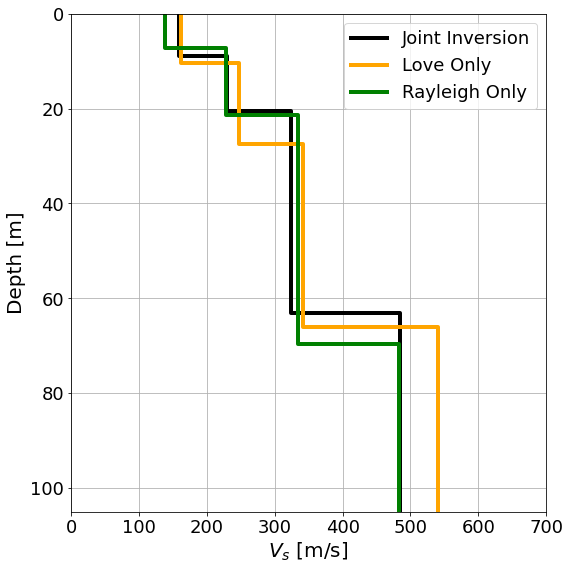

In [1686]:
i_param = 2

model1 = np.load('./inversion_new/mean_model.npz')['mean_model_joint']
model2 = np.load('./inversion_new/mean_model.npz')['mean_model_L']
model3 = np.load('./inversion_new/mean_model.npz')['mean_model_R']

fig, ax = plt.subplots(figsize=(8,8))
depthplot(model1[:,0]*1e3, model1[:, i_param]*1e3, None, 
          plot_args={"color":"k", "linewidth":4, "linestyle":"-", "label":"Joint Inversion"}, ax=ax)
depthplot(model2[:,0]*1e3, model2[:, i_param]*1e3, None, 
          plot_args={"color":"orange", "linewidth":4, "linestyle":"-", "label":"Love Only"}, ax=ax)
depthplot(model3[:,0]*1e3, model3[:, i_param]*1e3, None, 
          plot_args={"color":"green", "linewidth":4, "linestyle":"-", "label":"Rayleigh Only"}, ax=ax)

ax.set_xlabel("$V_s$ [m/s]")
ax.set_ylabel("Depth [m]")
ax.legend()

ax.set_xlim([0, 700])
ax.set_ylim([105, 0])
ax.grid()
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_compare.png', dpi=300)